# Predicción de Exitus (fallecimiento). Comparativa final

In [1]:
# Load Libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd 
import multiprocessing
import random
from sklearn.metrics import roc_auc_score as metric
import seaborn as sns
from matplotlib import pyplot as plt




from sklearn.preprocessing import scale
from sklearn.preprocessing import OneHotEncoder
import timeit

## Dataset

Leamos el dataset a utilizar.

In [2]:
# Load the dataset 
X = pd.read_csv("datasets/dat_sanidad_raw.csv", sep='|', decimal=',', encoding='latin-1')
X.shape

(32706, 10)

El dataset consta de:

- 32706 **filas** o instancias
- 10 **columnas** o variables.

Veamos su contenido.

In [3]:
X.head()

,gravedad,pct_mortalidad_norma,edad_dias,numproc,potencial_ambul,proc,estancia_esperada,tipgrd,tiping,exitus
0,4,0.408730,12596.0,21,0,1,NaN,Q,1,0
1,4,NaN,20973.0,22,0,1,99.0,Q,1,0
2,4,0.278481,19611.0,19,0,1,NaN,Q,1,0
3,3,0.150289,13583.0,22,0,1,100.0,Q,1,0
4,1,0.016573,18042.0,2,0,1,NaN,Q,1,0


- **gravedad**: Gravedad dentro del GRD. Valores de 1 a 4: Categorica

- **pct_mortalidad_norma**: Tasa de mortalidad histórica para ese GRD: Numérica
        
- **edad_dias**: Edad en días del paciente: Numérica

- **numproc**: Número de procedimientos que se han llevado a cabo al paciente a las 24 horas: Numérica
    
- **potencial_ambul**: Flag (valor 0 = no / 1 = sí) que indica si el caso se ha catalogado como potencialmente ambulatorio, es decir, no requiere ingreso: Categórica
    
- **proc**: Procedencia del paciente. Categórica

- **estancia_esperada**: Número de días que se espera que el paciente esté ingresado en el hospital por este episodio asistencial: Numérica

- **tipgrd**: GRD médico (M) o de quirófano (Q): Categórica
    
- **tiping**: Tipo de ingreso: Programado, urgente...: Categórica
    
- **exitus**: 1 = El paciente falleció: Categórica

De estas variables, fecing la usaremos para realizar el split en train/validacion/test, exitus es el target y las 10 variables restantes serán el input de nuestro modelo.

## Exploratorio

In [4]:
# Cambiamos el tipo de datos
X.describe(include='all')

,gravedad,pct_mortalidad_norma,edad_dias,numproc,potencial_ambul,proc,estancia_esperada,tipgrd,tiping,exitus
count,32706.000000,29399.000000,32232.000000,32706.000000,32706.000000,32706.000000,5127.000000,32706,32706.000000,32706.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23137,NaN,NaN
mean,1.623800,0.030175,19237.308265,4.074940,0.062649,1.532043,4.806319,NaN,1.271510,0.038403
std,0.930471,0.066510,9314.861421,2.819762,0.242334,1.371549,6.079437,NaN,0.474676,0.192169
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,NaN,1.000000,0.000000
25%,1.000000,0.000000,12350.000000,2.000000,0.000000,1.000000,2.000000,NaN,1.000000,0.000000
50%,1.000000,0.001095,19914.500000,3.000000,0.000000,1.000000,3.000000,NaN,1.000000,0.000000
75%,2.000000,0.028365,26936.250000,5.000000,0.000000,2.000000,6.000000,NaN,2.000000,0.000000


In [5]:
X.dtypes

gravedad                  int64
pct_mortalidad_norma    float64
edad_dias               float64
numproc                   int64
potencial_ambul           int64
proc                      int64
estancia_esperada       float64
tipgrd                   object
tiping                    int64
exitus                    int64
dtype: object

In [6]:
# Casos de exitus en porcentaje
100 * np.sum(X['exitus'] == 1) / X.shape[0]

3.8402739558490797

## Pre-procesado

### Fill missing values

Porcentaje de missing values para cada variable

In [7]:
X.apply(lambda x: 100*np.sum(x.isna())/len(x))

gravedad                 0.000000
pct_mortalidad_norma    10.111295
edad_dias                1.449275
numproc                  0.000000
potencial_ambul          0.000000
proc                     0.000000
estancia_esperada       84.323977
tipgrd                   0.000000
tiping                   0.000000
exitus                   0.000000
dtype: float64

* **estancia_esperada**: supondremos que los missing values corresponden a que se espera que el paciente pase 0 días ingresado


In [8]:
X['estancia_esperada'] = X['estancia_esperada'].fillna(0)

* **edad_dias**: rellenamos los missing values con la media


In [9]:
media_edad = X['edad_dias'].mean()
X['edad_dias'] = X['edad_dias'].fillna(media_edad)

* **pct_mortalidad_norma**: rellenamos missing values con la media de pct_mortalidad_norma para cada grupo de gravedad, ya que dependiendo del grupo este valor varia bastante

In [10]:
# Vemos el valor medio de pct_mortalidad_norma para cada valor de gravedad
gravedades = X['gravedad'].unique()

for gravedad in gravedades:
    print(f"media pct_mortalidad_norma para gravedad {gravedad}")
    print(X[X['gravedad'] == gravedad]['pct_mortalidad_norma'].mean())

media pct_mortalidad_norma para gravedad 4
0.20891454690759004
media pct_mortalidad_norma para gravedad 3
0.08817547022181497
media pct_mortalidad_norma para gravedad 1
0.00142383499085708
media pct_mortalidad_norma para gravedad 2
0.02847451930646185


In [11]:
medias = X[['gravedad', 'pct_mortalidad_norma']].groupby('gravedad').mean()

X['pct_mortalidad_norma'] = X['pct_mortalidad_norma'].fillna(X['gravedad'].map(medias['pct_mortalidad_norma']))

Comprobamos que ya no tenemos missing values en nuestro dataset

In [12]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32706 entries, 0 to 32705
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   gravedad              32706 non-null  int64  
 1   pct_mortalidad_norma  32706 non-null  float64
 2   edad_dias             32706 non-null  float64
 3   numproc               32706 non-null  int64  
 4   potencial_ambul       32706 non-null  int64  
 5   proc                  32706 non-null  int64  
 6   estancia_esperada     32706 non-null  float64
 7   tipgrd                32706 non-null  object 
 8   tiping                32706 non-null  int64  
 9   exitus                32706 non-null  int64  
dtypes: float64(3), int64(6), object(1)
memory usage: 2.5+ MB


### One-Hot Encoding

Utilizaremos la técnica de one-hot encoding.

<img src="../figures/oh.png" width="50%">

Seleccionemos las variables categóricas en primer lugar.

In [13]:
categorical_vars = set(['gravedad', 'proc', 'tiping', 'tipgrd'])
numerical_vars = set(X.columns) - categorical_vars
categorical_vars = list(categorical_vars)
numerical_vars = list(numerical_vars)

In [14]:
print(categorical_vars)
print(numerical_vars)

['gravedad', 'tiping', 'proc', 'tipgrd']
['estancia_esperada', 'potencial_ambul', 'edad_dias', 'exitus', 'numproc', 'pct_mortalidad_norma']


Realizamos one hot encoding de las variables categoricas

In [15]:
ohe = OneHotEncoder(sparse = False)
ohe_fit = ohe.fit(X[categorical_vars])
X_ohe = pd.DataFrame(ohe.fit_transform(X[categorical_vars]))
X_ohe.columns = pd.DataFrame(ohe_fit.get_feature_names_out())
X = pd.concat((X_ohe, X[numerical_vars].reset_index()), axis=1)
del X['index']

### Tipificar

Ahora vamos a tipificar los datos, es decir, llevarlos a media 0 y desviación estándar 1.

<img src="../figures/tipify.png" width="50%">

In [16]:
y = X['exitus'] # target
del X['exitus']
X_scale = pd.DataFrame(scale(X))
X_scale.columns = X.columns
X = X_scale
X.columns = X_scale.columns
print(X.head())

   (gravedad_1,)  (gravedad_2,)  (gravedad_3,)  (gravedad_4,)  (tiping_1,)  \
0      -1.322185      -0.435743      -0.417921       4.120705     0.589285   
1      -1.322185      -0.435743      -0.417921       4.120705     0.589285   
2      -1.322185      -0.435743      -0.417921       4.120705     0.589285   
3      -1.322185      -0.435743       2.392797      -0.242677     0.589285   
4       0.756324      -0.435743      -0.417921      -0.242677     0.589285   

   (tiping_2,)  (tiping_3,)  (proc_1,)  (proc_2,)  (proc_3,)  ...  (proc_7,)  \
0      -0.5681    -0.118114   0.589002  -0.471911  -0.128712  ...  -0.009578   
1      -0.5681    -0.118114   0.589002  -0.471911  -0.128712  ...  -0.009578   
2      -0.5681    -0.118114   0.589002  -0.471911  -0.128712  ...  -0.009578   
3      -0.5681    -0.118114   0.589002  -0.471911  -0.128712  ...  -0.009578   
4      -0.5681    -0.118114   0.589002  -0.471911  -0.128712  ...  -0.009578   

   (proc_8,)  (proc_9,)  (tipgrd_M,)  (tipgrd_Q,) 

### Split en Train/Validación/Test

Utilizaremos a modo de ejemplo los ratios habitualmente recomendados:

• Train: 70%.

• Validación: 15%.

• Test: 15%.


In [17]:
perc_values = [0.7, 0.15, 0.15];

Creamos los conjuntos de train, validacion y test con el tamaño seleccionado.

In [18]:
# dimensiones de los conjuntos de train y test
n_train = int(X.shape[0] * perc_values[0])
n_val = int(X.shape[0] * perc_values[1])
n_test = int(X.shape[0] * perc_values[2])

# selección del conjunto de train
X_train = X.iloc[:n_train]
y_train = y.iloc[:n_train]

# selección del conjunto de validación
X_val = X.iloc[(n_train):(n_train+n_val)]
y_val = y.iloc[(n_train):(n_train+n_val)]

# selección del conjunto de test
X_test = X.iloc[(n_train+n_val):]
y_test = y.iloc[(n_train+n_val):]

Visualizamos el tamaño de los 3 subdatasets

In [19]:
print('Train data size = ' + str(X_train.shape))
print('Train target size = ' + str(y_train.shape))
print('Validation data size = ' + str(X_val.shape))
print('Validation target size = ' + str(y_val.shape))
print('Test data size = ' + str(X_test.shape))
print('Test target size = ' + str(y_test.shape))

Train data size = (22894, 22)
Train target size = (22894,)
Validation data size = (4905, 22)
Validation target size = (4905,)
Test data size = (4907, 22)
Test target size = (4907,)


# Grid Search

Vamos a proceder a realizar un grid search que compare todos los modelos de clasificación que hemos visto, es decir:

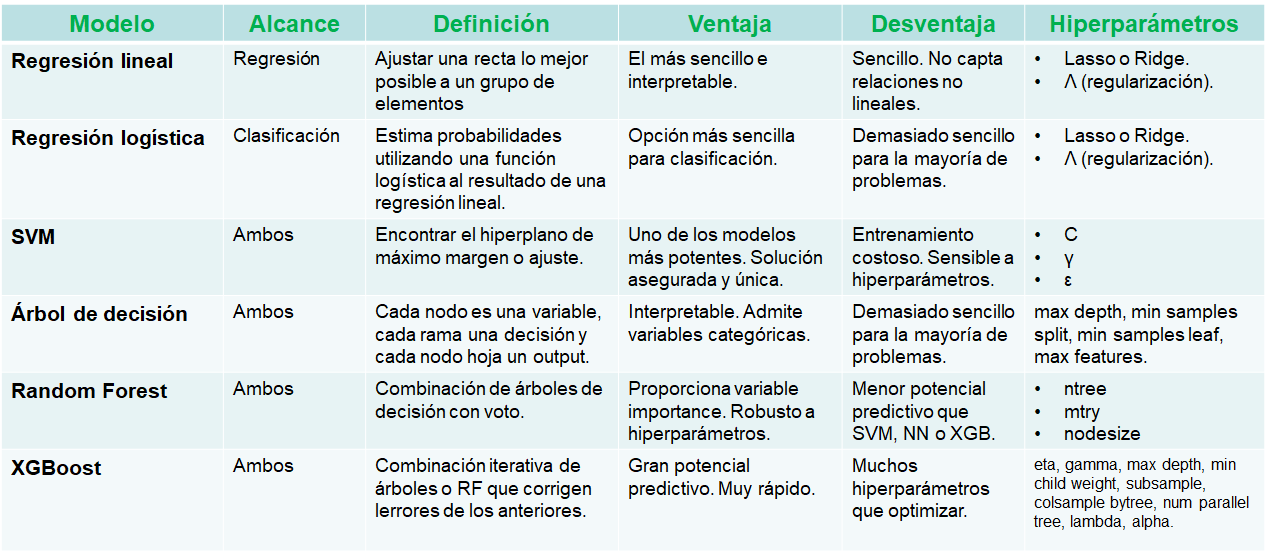

Importamos todos los modelos que vamos a usar.

In [20]:
from sklearn.linear_model import LinearRegression # Regresión lineal
from sklearn.linear_model import LogisticRegression # Regresión logística
from sklearn.svm import SVC #svm
from sklearn.tree import DecisionTreeClassifier # Arbol de decisión
from sklearn.ensemble import RandomForestClassifier # Random Forest
from xgboost import XGBClassifier # XGBoost

In [21]:
XGBClassifier?

Importamos la métrica.

In [22]:
from sklearn.metrics import roc_auc_score as metric;

Definimos algunos parámetros generales.

In [23]:
random_state = 1;
n_estimators = 10
nthread = multiprocessing.cpu_count() - 1;
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1);

Vamos a calcular los puntos recomendados por Cherkassky para la SVM.

In [24]:
n = X_train.shape[0];
d = X_train.shape[1];
m = np.mean(y_train);
s = np.std(y_train);
C_cherk = np.max([np.abs(m + 3*s),np.abs(m - 3*s)]);
gamma_cherk = np.power(0.2, 1/d)

Definimos el grid a llevar a cabo

In [25]:
# Regresion Logística
regularization_values = ['l1', 'l2', 'none'];
penalty_values = [1, 10, 100];

# SVM
C_values = [C_cherk, 5e-03, 4.5e-03, 4e-03];
gamma_kernel_values = [gamma_cherk, 3.26e-09, 3.255e-09, 3.25e-09];

# Arbol de Decision
max_depth_values = [None, 6, 20];
min_samples_split_values = [2, 5, 20];
min_samples_leaf_values = [1, 5, 20];
max_features_values = [None, 1, 2];


# Random Forest
ntrees_values = [10, 50, 100]
max_depth_values = [10,  100, None]
min_samples_split_values = [2, 4, 12]
min_samples_leaf_values = [1, 2, 4]
max_features_values = [None, 0.01]

# Xgboost
nrounds_values = [2, 10]
eta_values = [0.3, 0.99]
gamma_values = [0, 1]
max_depth_values = [6, 20]
min_child_weight_values = [1, 20]
subsample_values = [0.1, 1]
colsample_bytree_values = [0.1, 1]
num_parallel_tree_values = [1, 20]
lambda_values = [0, 1]
alpha_values = [0, 1]

In [26]:
params_values = [{'model': 'logistic regression',
                  'regularization': regularization_values,
                 'penalty': penalty_values},
                 {'model': 'svm',
                  'C': C_values,
                 'gamma_kernel': gamma_kernel_values},
                 {'model': 'decision tree',
                 'max_depth': max_depth_values,
                 'min_samples_split': min_samples_split_values,
                 'min_samples_leaf': min_samples_leaf_values,
                 'max_features': max_features_values},
                 {'model': 'random forest',
                  'n_trees': ntrees_values,
                 'max_depth': max_depth_values,
                 'min_samples_split': min_samples_split_values,
                 'min_samples_leaf': min_samples_leaf_values,
                 'max_features': max_features_values},
                 {'model': 'xgboost',
                  'nrounds': nrounds_values,
                  'eta': eta_values,
                 'gamma': gamma_values,
                 'max_depth': max_depth_values,
                 'min_child_weight': min_child_weight_values,
                 'subsample': subsample_values,
                 'colsample_bytree': colsample_bytree_values,
                 'num_parallel_tree': num_parallel_tree_values,
                 'lambda': lambda_values,
                 'alpha': alpha_values}]

In [27]:
total_iteraciones = 0
for params in params_values:
    if params['model'] == 'logistic regression':
        n = len(params['regularization'])*len(params['penalty'])
    elif params['model'] == 'svm':
        n = len(params['C'])*len(params['gamma_kernel'])
    elif params['model'] == 'decision tree':
        n = len(params['max_depth'])*len(params['min_samples_split'])*len(params['min_samples_leaf'])*len(params['max_features'])
    elif params['model'] == 'random forest':
        n = len(params['n_trees'])*len(params['max_depth'])*len(params['min_samples_split'])*len(params['min_samples_leaf'])*len(params['max_features'])
    elif params['model'] == 'xgboost':
        n = len(params['nrounds'])*len(params['eta'])*len(params['gamma'])*len(params['max_depth'])*len(params['min_child_weight'])*len(params['subsample'])*len(params['colsample_bytree'])*len(params['num_parallel_tree'])*len(params['lambda'])*len(params['alpha'])
    total_iteraciones = total_iteraciones + n;
    print(str(n)+ ' iteraciones de ' + str(params['model']))
print(str(total_iteraciones)+ ' iteraciones en total')        

9 iteraciones de logistic regression
16 iteraciones de svm
36 iteraciones de decision tree
108 iteraciones de random forest
1024 iteraciones de xgboost
1193 iteraciones en total


Ejecutamos el grid.

In [28]:
# Mirar time

grid_results = pd.DataFrame();
num_iter = 0
for params in params_values:   
    
    # Logistic Regression
    if params['model'] == 'logistic regression':
        for regularization in params['regularization']:
            for penalty in params['penalty']:  
                start = timeit.default_timer()
                
                # Actualizar contador
                num_iter += 1; 
                
                # print control iteracion modelo
                print('Inicio de iteracion ' + str(num_iter) + 
                      '. Regularizacion = ' + str(regularization) + 
                      ', Lambda = '  + str(penalty) +
                      '\n')
                
                # Entrenar modelo
                if regularization == 'l1':
                    model = LogisticRegression(penalty = regularization, 
                                               solver = 'liblinear', 
                                               C = penalty, 
                                               random_state = random_state)
                else:
                    model = LogisticRegression(penalty = regularization,
                                               solver = 'lbfgs', 
                                               C = penalty, 
                                               random_state = random_state)
               
                model.fit(X_train, np.array(y_train))

                # Generar predicciones
                pred_train_p = model.predict_proba(X_train)
                pred_val_p = model.predict_proba(X_val)

                # Calcular métricas de evaluación
                auc_train = metric(y_train, pred_train_p[:, 1])
                auc_val = metric(y_val, pred_val_p[:, 1])
                time = timeit.default_timer() - start

                print('Fin de iteracion ' + str(num_iter) + 
                     '. Regularizacion = ' + str(regularization) + 
                      ', Lambda = '  + str(penalty) +
                      '. AUC train = '  + str(auc_train) + 
                      ' -  AUC val = '  + str(auc_val)  + 
                      ' -  time = '  + str(time)  +
                      '\n')
                grid_results = grid_results.append(pd.DataFrame(data={'model':'Logistic Regression',
                                                                      'params': [{'regularization':[regularization],
                                                                                  'penalty':[penalty]}],
                                                                      'auc_train':[auc_train],
                                                                      'auc_val':[auc_val],
                                                                      'time':[time]},
                                                               columns=['model','params', 'auc_train', 'auc_val', 'time']), 
                                                   ignore_index=True)
                
    # SVM
    if params['model'] == 'svm':
        for C in params['C']:
            for gamma_kernel in params['gamma_kernel']:  
                start = timeit.default_timer()
                
                # Actualizar contador
                num_iter += 1; 
                
                # print control iteracion modelo
                print('Inicio de iteracion ' + str(num_iter) + 
                      '. C = ' + str(C) + 
                      ', gamma = '  + str(gamma_kernel) +
                      '\n')
                
                # Entrenar modelo               
                model = SVC(C = C, 
                            gamma = gamma_kernel, 
                            probability = True, 
                            random_state = random_state)
               
                model.fit(X_train, np.array(y_train))

                # Generar predicciones
                pred_train_p = model.predict_proba(X_train)
                pred_val_p = model.predict_proba(X_val)

                # Calcular métricas de evaluación
                auc_train = metric(y_train, pred_train_p[:, 1])
                auc_val = metric(y_val, pred_val_p[:, 1])
                time = timeit.default_timer() - start

                print('Fin de iteracion ' + str(num_iter) + 
                     '. C = ' + str(C) + 
                      ', gamma = '  + str(gamma_kernel) +
                      '. AUC train = '  + str(auc_train) + 
                      ' -  AUC val = '  + str(auc_val)  + 
                      ' -  time = '  + str(time)  +
                      '\n')
                grid_results = grid_results.append(pd.DataFrame(data={'model':'SVM',
                                                                     'params': [{'C':[C],
                                                                              'gamma_kernel':[gamma_kernel]}],
                                                                      'auc_train':[auc_train],
                                                                      'auc_val':[auc_val],
                                                                      'time':[time]},
                                                               columns=['model','params', 'auc_train', 'auc_val', 'time']), 
                                                   ignore_index=True)
    # Decision Tree
    if params['model'] == 'decision tree':
        for max_depth in params['max_depth']:
            for min_samples_split in params['min_samples_split']:  
                for min_samples_leaf in params['min_samples_leaf']:  
                    for max_features in params['max_features']:  
                        start = timeit.default_timer()
                
                        # Actualizar contador
                        num_iter += 1; 

                        # print control iteracion modelo
                        print('Inicio de iteracion ' + str(num_iter) + 
                              '. max_depth = ' + str(max_depth) + 
                              ', min_samples_split = '  + str(min_samples_split) +
                              ', min_samples_leaf = '  + str(min_samples_leaf) +
                              ', max_features = '  + str(max_features) +
                              '\n')

                        # Entrenar modelo               
                        model = DecisionTreeClassifier(max_depth = max_depth,
                                                      min_samples_split = min_samples_split,
                                                      min_samples_leaf = min_samples_leaf,
                                                      max_features = max_features, 
                                                       random_state = random_state)

                        model.fit(X_train, np.array(y_train))

                        # Generar predicciones
                        pred_train_p = model.predict_proba(X_train)
                        pred_val_p = model.predict_proba(X_val)

                        # Calcular métricas de evaluación
                        auc_train = metric(y_train, pred_train_p[:, 1])
                        auc_val = metric(y_val, pred_val_p[:, 1])
                        time = timeit.default_timer() - start

                        print('Fin de iteracion ' + str(num_iter) + 
                             '. max_depth = ' + str(max_depth) + 
                              ', min_samples_split = '  + str(min_samples_split) +
                              ', min_samples_leaf = '  + str(min_samples_leaf) +
                              ', max_features = '  + str(max_features) +
                              '. AUC train = '  + str(auc_train) + 
                              ' -  AUC val = '  + str(auc_val)  + 
                              ' -  time = '  + str(time)  +
                              '\n')
                        grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
                                                                              'params': [{'max_depth':[max_depth],
                                                                                          'min_samples_split':[min_samples_split],
                                                                                          'min_samples_leaf':[min_samples_leaf],
                                                                                          'max_features':[max_features]}],
                                                                      'auc_train':[auc_train],
                                                                      'auc_val':[auc_val],
                                                                      'time':[time]},
                                                                       columns=['model','params', 'auc_train', 'auc_val', 'time']), 
                                                           ignore_index=True)
    # Random Forest
    if params['model'] == 'random forest':
        for ntrees in params['n_trees']:
            for max_depth in params['max_depth']:
                for min_samples_split in params['min_samples_split']:  
                    for min_samples_leaf in params['min_samples_leaf']:  
                        for max_features in params['max_features']:  
                            start = timeit.default_timer()
                    
                            # Actualizar contador
                            num_iter += 1; 

                            # print control iteracion modelo
                            print('Inicio de iteracion ' + str(num_iter) + 
                                  '. n_trees = ' + str(ntrees) +
                                  '. max_depth = ' + str(max_depth) + 
                                  ', min_samples_split = '  + str(min_samples_split) +
                                  ', min_samples_leaf = '  + str(min_samples_leaf) +
                                  ', max_features = '  + str(max_features) +
                                  '\n')

                            # Entrenar modelo               
                            model = RandomForestClassifier(n_estimators = ntrees,
                                                            max_depth = max_depth,
                                                            min_samples_split = min_samples_split,
                                                            min_samples_leaf = min_samples_leaf,
                                                            max_features = max_features, 
                                                            random_state = random_state)

                            model.fit(X_train, np.array(y_train))

                            # Generar predicciones
                            pred_train_p = model.predict_proba(X_train)
                            pred_val_p = model.predict_proba(X_val)

                            # Calcular métricas de evaluación
                            auc_train = metric(y_train, pred_train_p[:, 1])
                            auc_val = metric(y_val, pred_val_p[:, 1])
                            time = timeit.default_timer() - start

                            print('Fin de iteracion ' + str(num_iter) + 
                                 '. n_trees = ' + str(ntrees) +
                                 '. max_depth = ' + str(max_depth) + 
                                  ', min_samples_split = '  + str(min_samples_split) +
                                  ', min_samples_leaf = '  + str(min_samples_leaf) +
                                  ', max_features = '  + str(max_features) +
                                  '. AUC train = '  + str(auc_train) + 
                                  ' -  AUC val = '  + str(auc_val)  + 
                                  ' -  time = '  + str(time)  +
                                  '\n')
                            grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
                                                                                  'params': [{'n_trees': [ntrees],
                                                                                              'max_depth':[max_depth],
                                                                                              'min_samples_split':[min_samples_split],
                                                                                              'min_samples_leaf':[min_samples_leaf],
                                                                                              'max_features':[max_features]}],
                                                                          'auc_train':[auc_train],
                                                                          'auc_val':[auc_val],
                                                                          'time':[time]},
                                                                           columns=['model','params', 'auc_train', 'auc_val', 'time']), 
                                                               ignore_index=True)
                        
    # XGBoost
    if params['model'] == 'xgboost':
        for nrounds in params['nrounds']:
            for eta in params['eta']:
                for gamma in params['gamma']:
                    for max_depth in params['max_depth']:
                        for min_child_weight in params['min_child_weight']:
                            for subsample in params['subsample']:
                                for colsample_bytree in params['colsample_bytree']:
                                    for num_parallel_tree in params['num_parallel_tree']:
                                        for lamda in params['lambda']:
                                            for alpha in params['alpha']:
                                                
                                                # Start timer
                                                start = timeit.default_timer()
                                                
                                                # Actualizar contador
                                                num_iter += 1;

                                                # print control iteracion modelo
                                                print('Inicio de iteracion ' + str(num_iter) + 
                                                      '. Parametro n_estimators = ' + str(nrounds) + 
                                                      ', parametro eta = ' + str(eta) + 
                                                      ', parametro gamma = '  + str(gamma) +
                                                      ', parametro max_depth = '  + str(max_depth) +
                                                      ', parametro min_child_weight = '  + str(min_child_weight) +
                                                      ', parametro subsample = '  + str(subsample) +
                                                      ', parametro colsample_bytree = '  + str(colsample_bytree) +
                                                      ', parametro num_parallel_tree = '  + str(num_parallel_tree) +
                                                      ', parametro lambda = '  + str(lamda) +
                                                      ', parametro alpha = '  + str(alpha) + 
                                                      '\n')
                                                
                                                # Entrenar modelo
                                                model = XGBClassifier(random_state = random_state,
                                                                      n_estimators = nrounds,
                                                                      learning_rate = eta, 
                                                                      gamma = gamma,
                                                                      max_depth = max_depth,
                                                                      min_child_weight = min_child_weight ,
                                                                      subsample = subsample,
                                                                      colsample_bytree = colsample_bytree,
                                                                      num_parallel_tree = num_parallel_tree,
                                                                      reg_lambda = lamda,
                                                                      reg_alpha = alpha)
                                                
                                                model.fit(X_train, np.array(y_train))

                                                # Generar predicciones
                                                pred_train_p = model.predict_proba(X_train)
                                                pred_val_p = model.predict_proba(X_val)

                                                # Calcular métricas de evaluación
                                                auc_train = metric(y_train, pred_train_p[:, 1])
                                                auc_val = metric(y_val, pred_val_p[:, 1])
                                                time = timeit.default_timer() - start

                                                print('Fin de iteracion ' + str(num_iter) + 
                                                      '. Parametro nrounds = ' + str(nrounds) + 
                                                      ', parametro eta = ' + str(eta) + 
                                                      ', parametro gamma = '  + str(gamma) +
                                                      ', parametro max_depth = '  + str(max_depth) +
                                                      ', parametro min_child_weight = '  + str(min_child_weight) +
                                                      ', parametro subsample = '  + str(subsample) +
                                                      ', parametro colsample_bytree = '  + str(colsample_bytree) +
                                                      ', parametro num_parallel_tree = '  + str(num_parallel_tree) +
                                                      ', parametro lambda = '  + str(lamda) +
                                                      ', parametro alpha = '  + str(alpha) + 
                                                      '. AUC train = '  + str(auc_train) + 
                                                      ' -  AUC val = '  + str(auc_val)  +
                                                      ' -  time = '  + str(time)  +
                                                      '\n')
                                                
                                                grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
                                                                                                      'params': [{'nrounds':[nrounds],
                                                                                                                  'eta':[eta],
                                                                                                                  'gamma':[gamma],
                                                                                                                  'max_depth':[max_depth],
                                                                                                                  'min_child_weight':[min_child_weight],
                                                                                                                  'subsample':[subsample],
                                                                                                                  'colsample_bytree':[colsample_bytree],
                                                                                                                  'num_parallel_tree':[num_parallel_tree],
                                                                                                                  'lamda':[lamda],
                                                                                                                  'alpha':[alpha]}],
                                                                                                      'auc_train':[auc_train],
                                                                                                      'auc_val':[auc_val],
                                                                                                      'time':[time]},
                                                                                                columns=['model','params', 'auc_train', 'auc_val', 'time']), 
                                                                           ignore_index=True)
        

Inicio de iteracion 1. Regularizacion = l1, Lambda = 1



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(


Fin de iteracion 1. Regularizacion = l1, Lambda = 1. AUC train = 0.9380891946360925 -  AUC val = 0.9360547411818597 -  time = 0.8539878999999999



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'Logistic Regression',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(


Inicio de iteracion 2. Regularizacion = l1, Lambda = 10



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'Logistic Regression',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be r

Fin de iteracion 2. Regularizacion = l1, Lambda = 10. AUC train = 0.9380401648734865 -  AUC val = 0.9359562528630326 -  time = 8.4320874

Inicio de iteracion 3. Regularizacion = l1, Lambda = 100



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'Logistic Regression',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be r

Fin de iteracion 3. Regularizacion = l1, Lambda = 100. AUC train = 0.9380383679711921 -  AUC val = 0.9358108108108107 -  time = 3.962780399999998

Inicio de iteracion 4. Regularizacion = l2, Lambda = 1

Fin de iteracion 4. Regularizacion = l2, Lambda = 1. AUC train = 0.9380486873243689 -  AUC val = 0.9366513971598717 -  time = 0.11801269999999775

Inicio de iteracion 5. Regularizacion = l2, Lambda = 10



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'Logistic Regression',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be r

Fin de iteracion 5. Regularizacion = l2, Lambda = 10. AUC train = 0.9380352362271931 -  AUC val = 0.9369869445716903 -  time = 0.13299549999999982

Inicio de iteracion 6. Regularizacion = l2, Lambda = 100

Fin de iteracion 6. Regularizacion = l2, Lambda = 100. AUC train = 0.9380370331294876 -  AUC val = 0.93692739349519 -  time = 0.10146839999999813

Inicio de iteracion 7. Regularizacion = none, Lambda = 1



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warni

Fin de iteracion 7. Regularizacion = none, Lambda = 1. AUC train = 0.9380360063281765 -  AUC val = 0.9369273934951902 -  time = 0.16839069999999978

Inicio de iteracion 8. Regularizacion = none, Lambda = 10

Fin de iteracion 8. Regularizacion = none, Lambda = 10. AUC train = 0.9380360063281765 -  AUC val = 0.9369273934951902 -  time = 0.16657539999999926



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'Logistic Regression',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-l

Inicio de iteracion 9. Regularizacion = none, Lambda = 100

Fin de iteracion 9. Regularizacion = none, Lambda = 100. AUC train = 0.9380360063281765 -  AUC val = 0.9369273934951902 -  time = 0.16930089999999964

Inicio de iteracion 10. C = 0.6169806179116835, gamma = 0.9294555738186685



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(


Fin de iteracion 10. C = 0.6169806179116835, gamma = 0.9294555738186685. AUC train = 0.8469511317019001 -  AUC val = 0.6551351351351352 -  time = 45.695727100000006

Inicio de iteracion 11. C = 0.6169806179116835, gamma = 3.26e-09



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'SVM',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
 

Fin de iteracion 11. C = 0.6169806179116835, gamma = 3.26e-09. AUC train = 0.93531413574262 -  AUC val = 0.9347194228126433 -  time = 18.287071499999996

Inicio de iteracion 12. C = 0.6169806179116835, gamma = 3.255e-09



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'SVM',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
 

Fin de iteracion 12. C = 0.6169806179116835, gamma = 3.255e-09. AUC train = 0.9355910897262625 -  AUC val = 0.934527027027027 -  time = 17.33194230000001

Inicio de iteracion 13. C = 0.6169806179116835, gamma = 3.25e-09



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'SVM',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
 

Fin de iteracion 13. C = 0.6169806179116835, gamma = 3.25e-09. AUC train = 0.9339399418779119 -  AUC val = 0.9325286303252406 -  time = 17.170864100000003

Inicio de iteracion 14. C = 0.005, gamma = 0.9294555738186685



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'SVM',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
 

Fin de iteracion 14. C = 0.005, gamma = 0.9294555738186685. AUC train = 0.6945671942628504 -  AUC val = 0.5469926706367384 -  time = 22.79456970000001

Inicio de iteracion 15. C = 0.005, gamma = 3.26e-09



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'SVM',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
 

Fin de iteracion 15. C = 0.005, gamma = 3.26e-09. AUC train = 0.933803788024057 -  AUC val = 0.9322869903802108 -  time = 17.364715899999993

Inicio de iteracion 16. C = 0.005, gamma = 3.255e-09



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'SVM',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
 

Fin de iteracion 16. C = 0.005, gamma = 3.255e-09. AUC train = 0.9368815736140813 -  AUC val = 0.9361704076958313 -  time = 17.200795099999993

Inicio de iteracion 17. C = 0.005, gamma = 3.25e-09



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'SVM',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
 

Fin de iteracion 17. C = 0.005, gamma = 3.25e-09. AUC train = 0.9350508895564809 -  AUC val = 0.9341101694915254 -  time = 17.266725000000008

Inicio de iteracion 18. C = 0.0045, gamma = 0.9294555738186685



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'SVM',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
 

Fin de iteracion 18. C = 0.0045, gamma = 0.9294555738186685. AUC train = 0.6460676205137446 -  AUC val = 0.5127989005955108 -  time = 22.1892474

Inicio de iteracion 19. C = 0.0045, gamma = 3.26e-09



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'SVM',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
 

Fin de iteracion 19. C = 0.0045, gamma = 3.26e-09. AUC train = 0.9359171504826093 -  AUC val = 0.9352072835547413 -  time = 16.85984959999999

Inicio de iteracion 20. C = 0.0045, gamma = 3.255e-09



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'SVM',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
 

Fin de iteracion 20. C = 0.0045, gamma = 3.255e-09. AUC train = 0.9354732642758111 -  AUC val = 0.9350961978928082 -  time = 17.17815189999999

Inicio de iteracion 21. C = 0.0045, gamma = 3.25e-09



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'SVM',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
 

Fin de iteracion 21. C = 0.0045, gamma = 3.25e-09. AUC train = 0.9355105885034705 -  AUC val = 0.9351820888685295 -  time = 17.403712000000013

Inicio de iteracion 22. C = 0.004, gamma = 0.9294555738186685



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'SVM',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
 

Fin de iteracion 22. C = 0.004, gamma = 0.9294555738186685. AUC train = 0.6754447140653554 -  AUC val = 0.5381046724690793 -  time = 21.695962699999995

Inicio de iteracion 23. C = 0.004, gamma = 3.26e-09



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'SVM',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
 

Fin de iteracion 23. C = 0.004, gamma = 3.26e-09. AUC train = 0.9332415116260862 -  AUC val = 0.931710948236372 -  time = 17.455122500000016

Inicio de iteracion 24. C = 0.004, gamma = 3.255e-09



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'SVM',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
 

Fin de iteracion 24. C = 0.004, gamma = 3.255e-09. AUC train = 0.9362381799125319 -  AUC val = 0.9353847915712323 -  time = 17.252308700000015

Inicio de iteracion 25. C = 0.004, gamma = 3.25e-09



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'SVM',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
 

Fin de iteracion 25. C = 0.004, gamma = 3.25e-09. AUC train = 0.9352877726189568 -  AUC val = 0.9345041227668347 -  time = 17.528051199999993

Inicio de iteracion 26. max_depth = 6, min_samples_split = 2, min_samples_leaf = 1, max_features = None

Fin de iteracion 26. max_depth = 6, min_samples_split = 2, min_samples_leaf = 1, max_features = None. AUC train = 0.9483517913704023 -  AUC val = 0.9061738433348603 -  time = 0.04435139999998228

Inicio de iteracion 27. max_depth = 6, min_samples_split = 2, min_samples_leaf = 1, max_features = 0.01

Fin de iteracion 27. max_depth = 6, min_samples_split = 2, min_samples_leaf = 1, max_features = 0.01. AUC train = 0.8770080960716379 -  AUC val = 0.8479557947778287 -  time = 0.018061900000020614

Inicio de iteracion 28. max_depth = 6, min_samples_split = 2, min_samples_leaf = 2, max_features = None

Fin de iteracion 28. max_depth = 6, min_samples_split = 2, min_samples_leaf = 2, max_features = None. AUC train = 0.9484227946810664 -  AUC val = 0.9

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'SVM',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
 

Fin de iteracion 30. max_depth = 6, min_samples_split = 2, min_samples_leaf = 4, max_features = None. AUC train = 0.9483974070186489 -  AUC val = 0.905428309665598 -  time = 0.05193420000000515

Inicio de iteracion 31. max_depth = 6, min_samples_split = 2, min_samples_leaf = 4, max_features = 0.01

Fin de iteracion 31. max_depth = 6, min_samples_split = 2, min_samples_leaf = 4, max_features = 0.01. AUC train = 0.8705162217921636 -  AUC val = 0.8432787448465415 -  time = 0.018234599999971124

Inicio de iteracion 32. max_depth = 6, min_samples_split = 4, min_samples_leaf = 1, max_features = None

Fin de iteracion 32. max_depth = 6, min_samples_split = 4, min_samples_leaf = 1, max_features = None. AUC train = 0.9483517913704023 -  AUC val = 0.9061738433348603 -  time = 0.0448306000000116

Inicio de iteracion 33. max_depth = 6, min_samples_split = 4, min_samples_leaf = 1, max_features = 0.01

Fin de iteracion 33. max_depth = 6, min_samples_split = 4, min_samples_leaf = 1, max_features = 0.

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:154: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data=

Fin de iteracion 35. max_depth = 6, min_samples_split = 4, min_samples_leaf = 2, max_features = 0.01. AUC train = 0.8768010929273155 -  AUC val = 0.8472921438387542 -  time = 0.018781300000000556

Inicio de iteracion 36. max_depth = 6, min_samples_split = 4, min_samples_leaf = 4, max_features = None

Fin de iteracion 36. max_depth = 6, min_samples_split = 4, min_samples_leaf = 4, max_features = None. AUC train = 0.9483974070186489 -  AUC val = 0.905428309665598 -  time = 0.04439489999998614

Inicio de iteracion 37. max_depth = 6, min_samples_split = 4, min_samples_leaf = 4, max_features = 0.01

Fin de iteracion 37. max_depth = 6, min_samples_split = 4, min_samples_leaf = 4, max_features = 0.01. AUC train = 0.8705162217921636 -  AUC val = 0.8432787448465415 -  time = 0.01717529999996259

Inicio de iteracion 38. max_depth = 6, min_samples_split = 12, min_samples_leaf = 1, max_features = None

Fin de iteracion 38. max_depth = 6, min_samples_split = 12, min_samples_leaf = 1, max_features =

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:154: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 40. max_depth = 6, min_samples_split = 12, min_samples_leaf = 2, max_features = None. AUC train = 0.9482303977853949 -  AUC val = 0.9057180485570316 -  time = 0.04603939999998374

Inicio de iteracion 41. max_depth = 6, min_samples_split = 12, min_samples_leaf = 2, max_features = 0.01

Fin de iteracion 41. max_depth = 6, min_samples_split = 12, min_samples_leaf = 2, max_features = 0.01. AUC train = 0.8707671463625691 -  AUC val = 0.8510278286761338 -  time = 0.01771400000001222

Inicio de iteracion 42. max_depth = 6, min_samples_split = 12, min_samples_leaf = 4, max_features = None

Fin de iteracion 42. max_depth = 6, min_samples_split = 12, min_samples_leaf = 4, max_features = None. AUC train = 0.9483233233040513 -  AUC val = 0.9053069170865783 -  time = 0.045050899999978355

Inicio de iteracion 43. max_depth = 6, min_samples_split = 12, min_samples_leaf = 4, max_features = 0.01

Fin de iteracion 43. max_depth = 6, min_samples_split = 12, min_samples_leaf = 4, max_feat

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:154: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Inicio de iteracion 45. max_depth = 20, min_samples_split = 2, min_samples_leaf = 1, max_features = 0.01

Fin de iteracion 45. max_depth = 20, min_samples_split = 2, min_samples_leaf = 1, max_features = 0.01. AUC train = 0.9908871126937542 -  AUC val = 0.7440202702702703 -  time = 0.023541299999976673

Inicio de iteracion 46. max_depth = 20, min_samples_split = 2, min_samples_leaf = 2, max_features = None

Fin de iteracion 46. max_depth = 20, min_samples_split = 2, min_samples_leaf = 2, max_features = None. AUC train = 0.994991263204344 -  AUC val = 0.6756854099862574 -  time = 0.06040410000002794

Inicio de iteracion 47. max_depth = 20, min_samples_split = 2, min_samples_leaf = 2, max_features = 0.01

Fin de iteracion 47. max_depth = 20, min_samples_split = 2, min_samples_leaf = 2, max_features = 0.01. AUC train = 0.9818372709880113 -  AUC val = 0.7852336234539625 -  time = 0.023080499999991844

Inicio de iteracion 48. max_depth = 20, min_samples_split = 2, min_samples_leaf = 4, max_f

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:154: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 48. max_depth = 20, min_samples_split = 2, min_samples_leaf = 4, max_features = None. AUC train = 0.9875084999896037 -  AUC val = 0.7430582913421896 -  time = 0.06154750000001741

Inicio de iteracion 49. max_depth = 20, min_samples_split = 2, min_samples_leaf = 4, max_features = 0.01

Fin de iteracion 49. max_depth = 20, min_samples_split = 2, min_samples_leaf = 4, max_features = 0.01. AUC train = 0.9488532297906891 -  AUC val = 0.8639252175904718 -  time = 0.019899500000008175

Inicio de iteracion 50. max_depth = 20, min_samples_split = 4, min_samples_leaf = 1, max_features = None

Fin de iteracion 50. max_depth = 20, min_samples_split = 4, min_samples_leaf = 1, max_features = None. AUC train = 0.9971319385777724 -  AUC val = 0.6545928767750803 -  time = 0.062101700000027904

Inicio de iteracion 51. max_depth = 20, min_samples_split = 4, min_samples_leaf = 1, max_features = 0.01

Fin de iteracion 51. max_depth = 20, min_samples_split = 4, min_samples_leaf = 1, max_fea

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:154: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 52. max_depth = 20, min_samples_split = 4, min_samples_leaf = 2, max_features = None. AUC train = 0.994991263204344 -  AUC val = 0.6756854099862574 -  time = 0.06295119999998633

Inicio de iteracion 53. max_depth = 20, min_samples_split = 4, min_samples_leaf = 2, max_features = 0.01

Fin de iteracion 53. max_depth = 20, min_samples_split = 4, min_samples_leaf = 2, max_features = 0.01. AUC train = 0.9818372709880113 -  AUC val = 0.7852336234539625 -  time = 0.023843100000021877

Inicio de iteracion 54. max_depth = 20, min_samples_split = 4, min_samples_leaf = 4, max_features = None

Fin de iteracion 54. max_depth = 20, min_samples_split = 4, min_samples_leaf = 4, max_features = None. AUC train = 0.9875084999896037 -  AUC val = 0.7430582913421896 -  time = 0.06089830000001939

Inicio de iteracion 55. max_depth = 20, min_samples_split = 4, min_samples_leaf = 4, max_features = 0.01

Fin de iteracion 55. max_depth = 20, min_samples_split = 4, min_samples_leaf = 4, max_featu

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:154: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 56. max_depth = 20, min_samples_split = 12, min_samples_leaf = 1, max_features = None. AUC train = 0.9898793328769202 -  AUC val = 0.7404088410444343 -  time = 0.06205159999996113

Inicio de iteracion 57. max_depth = 20, min_samples_split = 12, min_samples_leaf = 1, max_features = 0.01

Fin de iteracion 57. max_depth = 20, min_samples_split = 12, min_samples_leaf = 1, max_features = 0.01. AUC train = 0.9745608691667739 -  AUC val = 0.8510140861200184 -  time = 0.024150200000008226

Inicio de iteracion 58. max_depth = 20, min_samples_split = 12, min_samples_leaf = 2, max_features = None

Fin de iteracion 58. max_depth = 20, min_samples_split = 12, min_samples_leaf = 2, max_features = None. AUC train = 0.9883884173731702 -  AUC val = 0.7249169720568026 -  time = 0.06077579999998761

Inicio de iteracion 59. max_depth = 20, min_samples_split = 12, min_samples_leaf = 2, max_features = 0.01

Fin de iteracion 59. max_depth = 20, min_samples_split = 12, min_samples_leaf = 2, m

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:154: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 60. max_depth = 20, min_samples_split = 12, min_samples_leaf = 4, max_features = None. AUC train = 0.9849205499650502 -  AUC val = 0.7600973431058178 -  time = 0.06054890000001478

Inicio de iteracion 61. max_depth = 20, min_samples_split = 12, min_samples_leaf = 4, max_features = 0.01

Fin de iteracion 61. max_depth = 20, min_samples_split = 12, min_samples_leaf = 4, max_features = 0.01. AUC train = 0.9677536898746866 -  AUC val = 0.8617590471827759 -  time = 0.022771099999999933

Inicio de iteracion 62. n_trees = 10. max_depth = 6, min_samples_split = 2, min_samples_leaf = 1, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 62. n_trees = 10. max_depth = 6, min_samples_split = 2, min_samples_leaf = 1, max_features = None. AUC train = 0.9555217138956764 -  AUC val = 0.9336354786990381 -  time = 0.25494370000001254

Inicio de iteracion 63. n_trees = 10. max_depth = 6, min_samples_split = 2, min_samples_leaf = 1, max_features = 0.01

Fin de iteracion 63. n_trees = 10. max_depth = 6, min_samples_split = 2, min_samples_leaf = 1, max_features = 0.01. AUC train = 0.9404029373705107 -  AUC val = 0.9235020613834173 -  time = 0.06968960000000379

Inicio de iteracion 64. n_trees = 10. max_depth = 6, min_samples_split = 2, min_samples_leaf = 2, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 64. n_trees = 10. max_depth = 6, min_samples_split = 2, min_samples_leaf = 2, max_features = None. AUC train = 0.9545971819951418 -  AUC val = 0.9317962666055888 -  time = 0.279090999999994

Inicio de iteracion 65. n_trees = 10. max_depth = 6, min_samples_split = 2, min_samples_leaf = 2, max_features = 0.01

Fin de iteracion 65. n_trees = 10. max_depth = 6, min_samples_split = 2, min_samples_leaf = 2, max_features = 0.01. AUC train = 0.9375160854842897 -  AUC val = 0.9225612688960146 -  time = 0.07151070000003301

Inicio de iteracion 66. n_trees = 10. max_depth = 6, min_samples_split = 2, min_samples_leaf = 4, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 66. n_trees = 10. max_depth = 6, min_samples_split = 2, min_samples_leaf = 4, max_features = None. AUC train = 0.9538097280696417 -  AUC val = 0.9333623453962437 -  time = 0.2590891000000397

Inicio de iteracion 67. n_trees = 10. max_depth = 6, min_samples_split = 2, min_samples_leaf = 4, max_features = 0.01

Fin de iteracion 67. n_trees = 10. max_depth = 6, min_samples_split = 2, min_samples_leaf = 4, max_features = 0.01. AUC train = 0.9364259562023035 -  AUC val = 0.9227439303710491 -  time = 0.06796950000000379

Inicio de iteracion 68. n_trees = 10. max_depth = 6, min_samples_split = 4, min_samples_leaf = 1, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 68. n_trees = 10. max_depth = 6, min_samples_split = 4, min_samples_leaf = 1, max_features = None. AUC train = 0.9552969214186389 -  AUC val = 0.9334934722858453 -  time = 0.25615830000003825

Inicio de iteracion 69. n_trees = 10. max_depth = 6, min_samples_split = 4, min_samples_leaf = 1, max_features = 0.01

Fin de iteracion 69. n_trees = 10. max_depth = 6, min_samples_split = 4, min_samples_leaf = 1, max_features = 0.01. AUC train = 0.9396214388926153 -  AUC val = 0.9244840815391663 -  time = 0.06768840000000864

Inicio de iteracion 70. n_trees = 10. max_depth = 6, min_samples_split = 4, min_samples_leaf = 2, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 70. n_trees = 10. max_depth = 6, min_samples_split = 4, min_samples_leaf = 2, max_features = None. AUC train = 0.9545971819951418 -  AUC val = 0.9317962666055888 -  time = 0.2534806999999546

Inicio de iteracion 71. n_trees = 10. max_depth = 6, min_samples_split = 4, min_samples_leaf = 2, max_features = 0.01

Fin de iteracion 71. n_trees = 10. max_depth = 6, min_samples_split = 4, min_samples_leaf = 2, max_features = 0.01. AUC train = 0.9375160854842897 -  AUC val = 0.9225612688960146 -  time = 0.06694630000004054

Inicio de iteracion 72. n_trees = 10. max_depth = 6, min_samples_split = 4, min_samples_leaf = 4, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 72. n_trees = 10. max_depth = 6, min_samples_split = 4, min_samples_leaf = 4, max_features = None. AUC train = 0.9538097280696417 -  AUC val = 0.9333623453962437 -  time = 0.25174690000000055

Inicio de iteracion 73. n_trees = 10. max_depth = 6, min_samples_split = 4, min_samples_leaf = 4, max_features = 0.01

Fin de iteracion 73. n_trees = 10. max_depth = 6, min_samples_split = 4, min_samples_leaf = 4, max_features = 0.01. AUC train = 0.9364259562023035 -  AUC val = 0.9227439303710491 -  time = 0.06505640000000312

Inicio de iteracion 74. n_trees = 10. max_depth = 6, min_samples_split = 12, min_samples_leaf = 1, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 74. n_trees = 10. max_depth = 6, min_samples_split = 12, min_samples_leaf = 1, max_features = None. AUC train = 0.9541313992503837 -  AUC val = 0.932970109940449 -  time = 0.2532241000000113

Inicio de iteracion 75. n_trees = 10. max_depth = 6, min_samples_split = 12, min_samples_leaf = 1, max_features = 0.01

Fin de iteracion 75. n_trees = 10. max_depth = 6, min_samples_split = 12, min_samples_leaf = 1, max_features = 0.01. AUC train = 0.9395462513666083 -  AUC val = 0.9233743701328445 -  time = 0.06705849999997326

Inicio de iteracion 76. n_trees = 10. max_depth = 6, min_samples_split = 12, min_samples_leaf = 2, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 76. n_trees = 10. max_depth = 6, min_samples_split = 12, min_samples_leaf = 2, max_features = None. AUC train = 0.9535282048201648 -  AUC val = 0.9320132844709117 -  time = 0.2607979

Inicio de iteracion 77. n_trees = 10. max_depth = 6, min_samples_split = 12, min_samples_leaf = 2, max_features = 0.01

Fin de iteracion 77. n_trees = 10. max_depth = 6, min_samples_split = 12, min_samples_leaf = 2, max_features = 0.01. AUC train = 0.937868458024234 -  AUC val = 0.9228114979386166 -  time = 0.06657430000001341

Inicio de iteracion 78. n_trees = 10. max_depth = 6, min_samples_split = 12, min_samples_leaf = 4, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 78. n_trees = 10. max_depth = 6, min_samples_split = 12, min_samples_leaf = 4, max_features = None. AUC train = 0.9535791084951637 -  AUC val = 0.9334585432890519 -  time = 0.2526910000000271

Inicio de iteracion 79. n_trees = 10. max_depth = 6, min_samples_split = 12, min_samples_leaf = 4, max_features = 0.01

Fin de iteracion 79. n_trees = 10. max_depth = 6, min_samples_split = 12, min_samples_leaf = 4, max_features = 0.01. AUC train = 0.936680705607593 -  AUC val = 0.9227782867613376 -  time = 0.06484570000003487

Inicio de iteracion 80. n_trees = 10. max_depth = 20, min_samples_split = 2, min_samples_leaf = 1, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 80. n_trees = 10. max_depth = 20, min_samples_split = 2, min_samples_leaf = 1, max_features = None. AUC train = 0.9994876774858152 -  AUC val = 0.8645911589555656 -  time = 0.33855080000000726

Inicio de iteracion 81. n_trees = 10. max_depth = 20, min_samples_split = 2, min_samples_leaf = 1, max_features = 0.01

Fin de iteracion 81. n_trees = 10. max_depth = 20, min_samples_split = 2, min_samples_leaf = 1, max_features = 0.01. AUC train = 0.9962092292495649 -  AUC val = 0.90091903344022 -  time = 0.11875519999995277

Inicio de iteracion 82. n_trees = 10. max_depth = 20, min_samples_split = 2, min_samples_leaf = 2, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 82. n_trees = 10. max_depth = 20, min_samples_split = 2, min_samples_leaf = 2, max_features = None. AUC train = 0.9965852952297634 -  AUC val = 0.8800898992212551 -  time = 0.3361355000000117

Inicio de iteracion 83. n_trees = 10. max_depth = 20, min_samples_split = 2, min_samples_leaf = 2, max_features = 0.01

Fin de iteracion 83. n_trees = 10. max_depth = 20, min_samples_split = 2, min_samples_leaf = 2, max_features = 0.01. AUC train = 0.989849273268537 -  AUC val = 0.9269319743472286 -  time = 0.10583379999997078

Inicio de iteracion 84. n_trees = 10. max_depth = 20, min_samples_split = 2, min_samples_leaf = 4, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 84. n_trees = 10. max_depth = 20, min_samples_split = 2, min_samples_leaf = 4, max_features = None. AUC train = 0.9893715539585373 -  AUC val = 0.9081888456252863 -  time = 0.32484940000000506

Inicio de iteracion 85. n_trees = 10. max_depth = 20, min_samples_split = 2, min_samples_leaf = 4, max_features = 0.01

Fin de iteracion 85. n_trees = 10. max_depth = 20, min_samples_split = 2, min_samples_leaf = 4, max_features = 0.01. AUC train = 0.9756423219776809 -  AUC val = 0.9298803252404947 -  time = 0.10027830000001359

Inicio de iteracion 86. n_trees = 10. max_depth = 20, min_samples_split = 4, min_samples_leaf = 1, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 86. n_trees = 10. max_depth = 20, min_samples_split = 4, min_samples_leaf = 1, max_features = None. AUC train = 0.9985709236052125 -  AUC val = 0.8778647503435637 -  time = 0.3506641999999829

Inicio de iteracion 87. n_trees = 10. max_depth = 20, min_samples_split = 4, min_samples_leaf = 1, max_features = 0.01

Fin de iteracion 87. n_trees = 10. max_depth = 20, min_samples_split = 4, min_samples_leaf = 1, max_features = 0.01. AUC train = 0.9947329199944657 -  AUC val = 0.9079947320201558 -  time = 0.11007410000001983

Inicio de iteracion 88. n_trees = 10. max_depth = 20, min_samples_split = 4, min_samples_leaf = 2, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 88. n_trees = 10. max_depth = 20, min_samples_split = 4, min_samples_leaf = 2, max_features = None. AUC train = 0.9965852952297634 -  AUC val = 0.8800898992212551 -  time = 0.334576200000015

Inicio de iteracion 89. n_trees = 10. max_depth = 20, min_samples_split = 4, min_samples_leaf = 2, max_features = 0.01

Fin de iteracion 89. n_trees = 10. max_depth = 20, min_samples_split = 4, min_samples_leaf = 2, max_features = 0.01. AUC train = 0.989849273268537 -  AUC val = 0.9269319743472286 -  time = 0.10675030000004426

Inicio de iteracion 90. n_trees = 10. max_depth = 20, min_samples_split = 4, min_samples_leaf = 4, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 90. n_trees = 10. max_depth = 20, min_samples_split = 4, min_samples_leaf = 4, max_features = None. AUC train = 0.9893715539585373 -  AUC val = 0.9081888456252863 -  time = 0.33771999999999025

Inicio de iteracion 91. n_trees = 10. max_depth = 20, min_samples_split = 4, min_samples_leaf = 4, max_features = 0.01

Fin de iteracion 91. n_trees = 10. max_depth = 20, min_samples_split = 4, min_samples_leaf = 4, max_features = 0.01. AUC train = 0.9756423219776809 -  AUC val = 0.9298803252404947 -  time = 0.1047204999999849

Inicio de iteracion 92. n_trees = 10. max_depth = 20, min_samples_split = 12, min_samples_leaf = 1, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 92. n_trees = 10. max_depth = 20, min_samples_split = 12, min_samples_leaf = 1, max_features = None. AUC train = 0.9920417250980789 -  AUC val = 0.898602267521759 -  time = 0.34711110000000645

Inicio de iteracion 93. n_trees = 10. max_depth = 20, min_samples_split = 12, min_samples_leaf = 1, max_features = 0.01

Fin de iteracion 93. n_trees = 10. max_depth = 20, min_samples_split = 12, min_samples_leaf = 1, max_features = 0.01. AUC train = 0.9865943901223768 -  AUC val = 0.9230771873568484 -  time = 0.10879550000004201

Inicio de iteracion 94. n_trees = 10. max_depth = 20, min_samples_split = 12, min_samples_leaf = 2, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 94. n_trees = 10. max_depth = 20, min_samples_split = 12, min_samples_leaf = 2, max_features = None. AUC train = 0.9890039590891554 -  AUC val = 0.9029180027485111 -  time = 0.3336560999999847

Inicio de iteracion 95. n_trees = 10. max_depth = 20, min_samples_split = 12, min_samples_leaf = 2, max_features = 0.01

Fin de iteracion 95. n_trees = 10. max_depth = 20, min_samples_split = 12, min_samples_leaf = 2, max_features = 0.01. AUC train = 0.9814850781382963 -  AUC val = 0.9276271186440679 -  time = 0.10601850000000468

Inicio de iteracion 96. n_trees = 10. max_depth = 20, min_samples_split = 12, min_samples_leaf = 4, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 96. n_trees = 10. max_depth = 20, min_samples_split = 12, min_samples_leaf = 4, max_features = None. AUC train = 0.9858692373664292 -  AUC val = 0.9119147961520843 -  time = 0.324962400000004

Inicio de iteracion 97. n_trees = 10. max_depth = 20, min_samples_split = 12, min_samples_leaf = 4, max_features = 0.01

Fin de iteracion 97. n_trees = 10. max_depth = 20, min_samples_split = 12, min_samples_leaf = 4, max_features = 0.01. AUC train = 0.9728422348022496 -  AUC val = 0.9261663994502978 -  time = 0.10041029999996454

Inicio de iteracion 98. n_trees = 50. max_depth = 6, min_samples_split = 2, min_samples_leaf = 1, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 98. n_trees = 50. max_depth = 6, min_samples_split = 2, min_samples_leaf = 1, max_features = None. AUC train = 0.9578141505028889 -  AUC val = 0.9339481218506641 -  time = 1.1452580000000125

Inicio de iteracion 99. n_trees = 50. max_depth = 6, min_samples_split = 2, min_samples_leaf = 1, max_features = 0.01



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 99. n_trees = 50. max_depth = 6, min_samples_split = 2, min_samples_leaf = 1, max_features = 0.01. AUC train = 0.9444867828851732 -  AUC val = 0.9279666743014201 -  time = 0.28999129999999695

Inicio de iteracion 100. n_trees = 50. max_depth = 6, min_samples_split = 2, min_samples_leaf = 2, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 100. n_trees = 50. max_depth = 6, min_samples_split = 2, min_samples_leaf = 2, max_features = None. AUC train = 0.9570424066374491 -  AUC val = 0.933361200183234 -  time = 1.146452399999987

Inicio de iteracion 101. n_trees = 50. max_depth = 6, min_samples_split = 2, min_samples_leaf = 2, max_features = 0.01



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 101. n_trees = 50. max_depth = 6, min_samples_split = 2, min_samples_leaf = 2, max_features = 0.01. AUC train = 0.9429851629777547 -  AUC val = 0.9278378378378378 -  time = 0.28100139999997964

Inicio de iteracion 102. n_trees = 50. max_depth = 6, min_samples_split = 2, min_samples_leaf = 4, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 102. n_trees = 50. max_depth = 6, min_samples_split = 2, min_samples_leaf = 4, max_features = None. AUC train = 0.9557801854557187 -  AUC val = 0.9342624828218049 -  time = 1.217168299999969

Inicio de iteracion 103. n_trees = 50. max_depth = 6, min_samples_split = 2, min_samples_leaf = 4, max_features = 0.01



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 103. n_trees = 50. max_depth = 6, min_samples_split = 2, min_samples_leaf = 4, max_features = 0.01. AUC train = 0.9424750994264545 -  AUC val = 0.9297240036646818 -  time = 0.3109594999999672

Inicio de iteracion 104. n_trees = 50. max_depth = 6, min_samples_split = 4, min_samples_leaf = 1, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 104. n_trees = 50. max_depth = 6, min_samples_split = 4, min_samples_leaf = 1, max_features = None. AUC train = 0.9575462067007513 -  AUC val = 0.9339114750343565 -  time = 1.2051098000000025

Inicio de iteracion 105. n_trees = 50. max_depth = 6, min_samples_split = 4, min_samples_leaf = 1, max_features = 0.01



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 105. n_trees = 50. max_depth = 6, min_samples_split = 4, min_samples_leaf = 1, max_features = 0.01. AUC train = 0.9434590831229033 -  AUC val = 0.9269434264773249 -  time = 0.2828770000000418

Inicio de iteracion 106. n_trees = 50. max_depth = 6, min_samples_split = 4, min_samples_leaf = 2, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 106. n_trees = 50. max_depth = 6, min_samples_split = 4, min_samples_leaf = 2, max_features = None. AUC train = 0.9570424066374491 -  AUC val = 0.933361200183234 -  time = 1.1467852000000107

Inicio de iteracion 107. n_trees = 50. max_depth = 6, min_samples_split = 4, min_samples_leaf = 2, max_features = 0.01



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 107. n_trees = 50. max_depth = 6, min_samples_split = 4, min_samples_leaf = 2, max_features = 0.01. AUC train = 0.9429851629777547 -  AUC val = 0.9278378378378378 -  time = 0.28347949999999855

Inicio de iteracion 108. n_trees = 50. max_depth = 6, min_samples_split = 4, min_samples_leaf = 4, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 108. n_trees = 50. max_depth = 6, min_samples_split = 4, min_samples_leaf = 4, max_features = None. AUC train = 0.9557801854557187 -  AUC val = 0.9342624828218049 -  time = 1.163405800000021

Inicio de iteracion 109. n_trees = 50. max_depth = 6, min_samples_split = 4, min_samples_leaf = 4, max_features = 0.01



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 109. n_trees = 50. max_depth = 6, min_samples_split = 4, min_samples_leaf = 4, max_features = 0.01. AUC train = 0.9424750994264545 -  AUC val = 0.9297240036646818 -  time = 0.28353780000003326

Inicio de iteracion 110. n_trees = 50. max_depth = 6, min_samples_split = 12, min_samples_leaf = 1, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 110. n_trees = 50. max_depth = 6, min_samples_split = 12, min_samples_leaf = 1, max_features = None. AUC train = 0.9563722134216794 -  AUC val = 0.9339275080164912 -  time = 1.1894065999999839

Inicio de iteracion 111. n_trees = 50. max_depth = 6, min_samples_split = 12, min_samples_leaf = 1, max_features = 0.01



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 111. n_trees = 50. max_depth = 6, min_samples_split = 12, min_samples_leaf = 1, max_features = 0.01. AUC train = 0.9436974293772475 -  AUC val = 0.9288965872652315 -  time = 0.28575869999997394

Inicio de iteracion 112. n_trees = 50. max_depth = 6, min_samples_split = 12, min_samples_leaf = 2, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 112. n_trees = 50. max_depth = 6, min_samples_split = 12, min_samples_leaf = 2, max_features = None. AUC train = 0.9558779626105706 -  AUC val = 0.9335787906550619 -  time = 1.155996899999991

Inicio de iteracion 113. n_trees = 50. max_depth = 6, min_samples_split = 12, min_samples_leaf = 2, max_features = 0.01



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 113. n_trees = 50. max_depth = 6, min_samples_split = 12, min_samples_leaf = 2, max_features = 0.01. AUC train = 0.9427272304884005 -  AUC val = 0.928409871736143 -  time = 0.28108350000002247

Inicio de iteracion 114. n_trees = 50. max_depth = 6, min_samples_split = 12, min_samples_leaf = 4, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 114. n_trees = 50. max_depth = 6, min_samples_split = 12, min_samples_leaf = 4, max_features = None. AUC train = 0.955493451189588 -  AUC val = 0.9342556115437473 -  time = 1.1644456000000218

Inicio de iteracion 115. n_trees = 50. max_depth = 6, min_samples_split = 12, min_samples_leaf = 4, max_features = 0.01



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 115. n_trees = 50. max_depth = 6, min_samples_split = 12, min_samples_leaf = 4, max_features = 0.01. AUC train = 0.9419856232414423 -  AUC val = 0.9288897159871736 -  time = 0.2837149999999724

Inicio de iteracion 116. n_trees = 50. max_depth = 20, min_samples_split = 2, min_samples_leaf = 1, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 116. n_trees = 50. max_depth = 20, min_samples_split = 2, min_samples_leaf = 1, max_features = None. AUC train = 0.9999972019664272 -  AUC val = 0.9091765918460833 -  time = 1.597842700000001

Inicio de iteracion 117. n_trees = 50. max_depth = 20, min_samples_split = 2, min_samples_leaf = 1, max_features = 0.01



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 117. n_trees = 50. max_depth = 20, min_samples_split = 2, min_samples_leaf = 1, max_features = 0.01. AUC train = 0.9982602648685323 -  AUC val = 0.9260684837379752 -  time = 0.5467991999999526

Inicio de iteracion 118. n_trees = 50. max_depth = 20, min_samples_split = 2, min_samples_leaf = 2, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 118. n_trees = 50. max_depth = 20, min_samples_split = 2, min_samples_leaf = 2, max_features = None. AUC train = 0.9989030168192622 -  AUC val = 0.9123030233623455 -  time = 1.5613268999999832

Inicio de iteracion 119. n_trees = 50. max_depth = 20, min_samples_split = 2, min_samples_leaf = 2, max_features = 0.01



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 119. n_trees = 50. max_depth = 20, min_samples_split = 2, min_samples_leaf = 2, max_features = 0.01. AUC train = 0.9915171066381935 -  AUC val = 0.9348562757672927 -  time = 0.48800229999994826

Inicio de iteracion 120. n_trees = 50. max_depth = 20, min_samples_split = 2, min_samples_leaf = 4, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 120. n_trees = 50. max_depth = 20, min_samples_split = 2, min_samples_leaf = 4, max_features = None. AUC train = 0.9920709375953801 -  AUC val = 0.920837150710032 -  time = 1.5600466999999867

Inicio de iteracion 121. n_trees = 50. max_depth = 20, min_samples_split = 2, min_samples_leaf = 4, max_features = 0.01



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 121. n_trees = 50. max_depth = 20, min_samples_split = 2, min_samples_leaf = 4, max_features = 0.01. AUC train = 0.9778073582122158 -  AUC val = 0.9366954878607421 -  time = 0.4742901000000188

Inicio de iteracion 122. n_trees = 50. max_depth = 20, min_samples_split = 4, min_samples_leaf = 1, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 122. n_trees = 50. max_depth = 20, min_samples_split = 4, min_samples_leaf = 1, max_features = None. AUC train = 0.9998198733799963 -  AUC val = 0.9105182088868529 -  time = 1.6721955000000435

Inicio de iteracion 123. n_trees = 50. max_depth = 20, min_samples_split = 4, min_samples_leaf = 1, max_features = 0.01



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 123. n_trees = 50. max_depth = 20, min_samples_split = 4, min_samples_leaf = 1, max_features = 0.01. AUC train = 0.9969894442258215 -  AUC val = 0.9246982363719651 -  time = 0.5092182000000207

Inicio de iteracion 124. n_trees = 50. max_depth = 20, min_samples_split = 4, min_samples_leaf = 2, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 124. n_trees = 50. max_depth = 20, min_samples_split = 4, min_samples_leaf = 2, max_features = None. AUC train = 0.9989030168192622 -  AUC val = 0.9123030233623455 -  time = 1.5980996000000118

Inicio de iteracion 125. n_trees = 50. max_depth = 20, min_samples_split = 4, min_samples_leaf = 2, max_features = 0.01



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 125. n_trees = 50. max_depth = 20, min_samples_split = 4, min_samples_leaf = 2, max_features = 0.01. AUC train = 0.9915171066381935 -  AUC val = 0.9348562757672927 -  time = 0.48627449999997907

Inicio de iteracion 126. n_trees = 50. max_depth = 20, min_samples_split = 4, min_samples_leaf = 4, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 126. n_trees = 50. max_depth = 20, min_samples_split = 4, min_samples_leaf = 4, max_features = None. AUC train = 0.9920709375953801 -  AUC val = 0.920837150710032 -  time = 1.5540599999999927

Inicio de iteracion 127. n_trees = 50. max_depth = 20, min_samples_split = 4, min_samples_leaf = 4, max_features = 0.01



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 127. n_trees = 50. max_depth = 20, min_samples_split = 4, min_samples_leaf = 4, max_features = 0.01. AUC train = 0.9778073582122158 -  AUC val = 0.9366954878607421 -  time = 0.45673650000003363

Inicio de iteracion 128. n_trees = 50. max_depth = 20, min_samples_split = 12, min_samples_leaf = 1, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 128. n_trees = 50. max_depth = 20, min_samples_split = 12, min_samples_leaf = 1, max_features = None. AUC train = 0.9952679091475931 -  AUC val = 0.9200836005497022 -  time = 1.615984400000002

Inicio de iteracion 129. n_trees = 50. max_depth = 20, min_samples_split = 12, min_samples_leaf = 1, max_features = 0.01



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 129. n_trees = 50. max_depth = 20, min_samples_split = 12, min_samples_leaf = 1, max_features = 0.01. AUC train = 0.9891826225172907 -  AUC val = 0.931120590929913 -  time = 0.49438890000004676

Inicio de iteracion 130. n_trees = 50. max_depth = 20, min_samples_split = 12, min_samples_leaf = 2, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 130. n_trees = 50. max_depth = 20, min_samples_split = 12, min_samples_leaf = 2, max_features = None. AUC train = 0.9927858736782822 -  AUC val = 0.9217974118185983 -  time = 1.5534142999999858

Inicio de iteracion 131. n_trees = 50. max_depth = 20, min_samples_split = 12, min_samples_leaf = 2, max_features = 0.01



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 131. n_trees = 50. max_depth = 20, min_samples_split = 12, min_samples_leaf = 2, max_features = 0.01. AUC train = 0.9836383574978187 -  AUC val = 0.9358989922125516 -  time = 0.4784396000000015

Inicio de iteracion 132. n_trees = 50. max_depth = 20, min_samples_split = 12, min_samples_leaf = 4, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 132. n_trees = 50. max_depth = 20, min_samples_split = 12, min_samples_leaf = 4, max_features = None. AUC train = 0.9889896865509307 -  AUC val = 0.9234304855703162 -  time = 1.5581189999999765

Inicio de iteracion 133. n_trees = 50. max_depth = 20, min_samples_split = 12, min_samples_leaf = 4, max_features = 0.01



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 133. n_trees = 50. max_depth = 20, min_samples_split = 12, min_samples_leaf = 4, max_features = 0.01. AUC train = 0.9752475682136198 -  AUC val = 0.9359900366468163 -  time = 0.4463555000000383

Inicio de iteracion 134. n_trees = 100. max_depth = 6, min_samples_split = 2, min_samples_leaf = 1, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 134. n_trees = 100. max_depth = 6, min_samples_split = 2, min_samples_leaf = 1, max_features = None. AUC train = 0.958189908442694 -  AUC val = 0.9335186669720569 -  time = 2.325737199999992

Inicio de iteracion 135. n_trees = 100. max_depth = 6, min_samples_split = 2, min_samples_leaf = 1, max_features = 0.01



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 135. n_trees = 100. max_depth = 6, min_samples_split = 2, min_samples_leaf = 1, max_features = 0.01. AUC train = 0.9456832374429258 -  AUC val = 0.9318787219422813 -  time = 0.5627977999999985

Inicio de iteracion 136. n_trees = 100. max_depth = 6, min_samples_split = 2, min_samples_leaf = 2, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 136. n_trees = 100. max_depth = 6, min_samples_split = 2, min_samples_leaf = 2, max_features = None. AUC train = 0.9572510526638692 -  AUC val = 0.9333325698579937 -  time = 2.436483599999974

Inicio de iteracion 137. n_trees = 100. max_depth = 6, min_samples_split = 2, min_samples_leaf = 2, max_features = 0.01



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 137. n_trees = 100. max_depth = 6, min_samples_split = 2, min_samples_leaf = 2, max_features = 0.01. AUC train = 0.9438084009289472 -  AUC val = 0.9304500687127806 -  time = 0.5551441000000068

Inicio de iteracion 138. n_trees = 100. max_depth = 6, min_samples_split = 2, min_samples_leaf = 4, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 138. n_trees = 100. max_depth = 6, min_samples_split = 2, min_samples_leaf = 4, max_features = None. AUC train = 0.9560892526503668 -  AUC val = 0.933945831424645 -  time = 2.3253746999999976

Inicio de iteracion 139. n_trees = 100. max_depth = 6, min_samples_split = 2, min_samples_leaf = 4, max_features = 0.01



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 139. n_trees = 100. max_depth = 6, min_samples_split = 2, min_samples_leaf = 4, max_features = 0.01. AUC train = 0.943437135244878 -  AUC val = 0.9313129867155292 -  time = 0.550370799999996

Inicio de iteracion 140. n_trees = 100. max_depth = 6, min_samples_split = 4, min_samples_leaf = 1, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 140. n_trees = 100. max_depth = 6, min_samples_split = 4, min_samples_leaf = 1, max_features = None. AUC train = 0.9579210661894093 -  AUC val = 0.9335358451672011 -  time = 2.3498529000000303

Inicio de iteracion 141. n_trees = 100. max_depth = 6, min_samples_split = 4, min_samples_leaf = 1, max_features = 0.01



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 141. n_trees = 100. max_depth = 6, min_samples_split = 4, min_samples_leaf = 1, max_features = 0.01. AUC train = 0.9451686302958241 -  AUC val = 0.9309602611085662 -  time = 0.5619766000000368

Inicio de iteracion 142. n_trees = 100. max_depth = 6, min_samples_split = 4, min_samples_leaf = 2, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 142. n_trees = 100. max_depth = 6, min_samples_split = 4, min_samples_leaf = 2, max_features = None. AUC train = 0.9572510526638692 -  AUC val = 0.9333325698579937 -  time = 2.3354692999999997

Inicio de iteracion 143. n_trees = 100. max_depth = 6, min_samples_split = 4, min_samples_leaf = 2, max_features = 0.01



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 143. n_trees = 100. max_depth = 6, min_samples_split = 4, min_samples_leaf = 2, max_features = 0.01. AUC train = 0.9438084009289472 -  AUC val = 0.9304500687127806 -  time = 0.5575019000000339

Inicio de iteracion 144. n_trees = 100. max_depth = 6, min_samples_split = 4, min_samples_leaf = 4, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 144. n_trees = 100. max_depth = 6, min_samples_split = 4, min_samples_leaf = 4, max_features = None. AUC train = 0.9560892526503668 -  AUC val = 0.933945831424645 -  time = 2.344750999999974

Inicio de iteracion 145. n_trees = 100. max_depth = 6, min_samples_split = 4, min_samples_leaf = 4, max_features = 0.01



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 145. n_trees = 100. max_depth = 6, min_samples_split = 4, min_samples_leaf = 4, max_features = 0.01. AUC train = 0.943437135244878 -  AUC val = 0.9313129867155292 -  time = 0.554258300000015

Inicio de iteracion 146. n_trees = 100. max_depth = 6, min_samples_split = 12, min_samples_leaf = 1, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 146. n_trees = 100. max_depth = 6, min_samples_split = 12, min_samples_leaf = 1, max_features = None. AUC train = 0.9567827799259315 -  AUC val = 0.9335175217590471 -  time = 2.333953500000007

Inicio de iteracion 147. n_trees = 100. max_depth = 6, min_samples_split = 12, min_samples_leaf = 1, max_features = 0.01



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 147. n_trees = 100. max_depth = 6, min_samples_split = 12, min_samples_leaf = 1, max_features = 0.01. AUC train = 0.9440948784947505 -  AUC val = 0.9302347686669721 -  time = 0.6002894999999739

Inicio de iteracion 148. n_trees = 100. max_depth = 6, min_samples_split = 12, min_samples_leaf = 2, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 148. n_trees = 100. max_depth = 6, min_samples_split = 12, min_samples_leaf = 2, max_features = None. AUC train = 0.9561766847820088 -  AUC val = 0.933421896472744 -  time = 2.367630399999996

Inicio de iteracion 149. n_trees = 100. max_depth = 6, min_samples_split = 12, min_samples_leaf = 2, max_features = 0.01



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 149. n_trees = 100. max_depth = 6, min_samples_split = 12, min_samples_leaf = 2, max_features = 0.01. AUC train = 0.9428635897025177 -  AUC val = 0.9292871049015117 -  time = 0.5633652999999867

Inicio de iteracion 150. n_trees = 100. max_depth = 6, min_samples_split = 12, min_samples_leaf = 4, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 150. n_trees = 100. max_depth = 6, min_samples_split = 12, min_samples_leaf = 4, max_features = None. AUC train = 0.955744196069764 -  AUC val = 0.9338576500229043 -  time = 2.321334699999966

Inicio de iteracion 151. n_trees = 100. max_depth = 6, min_samples_split = 12, min_samples_leaf = 4, max_features = 0.01



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 151. n_trees = 100. max_depth = 6, min_samples_split = 12, min_samples_leaf = 4, max_features = 0.01. AUC train = 0.9425680506151438 -  AUC val = 0.9300458085203849 -  time = 0.5448291000000154

Inicio de iteracion 152. n_trees = 100. max_depth = 20, min_samples_split = 2, min_samples_leaf = 1, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(


Fin de iteracion 152. n_trees = 100. max_depth = 20, min_samples_split = 2, min_samples_leaf = 1, max_features = None. AUC train = 0.9999967912459027 -  AUC val = 0.9148597114063216 -  time = 3.2645749000000137

Inicio de iteracion 153. n_trees = 100. max_depth = 20, min_samples_split = 2, min_samples_leaf = 1, max_features = 0.01



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 153. n_trees = 100. max_depth = 20, min_samples_split = 2, min_samples_leaf = 1, max_features = 0.01. AUC train = 0.9987187316539485 -  AUC val = 0.9283371507100321 -  time = 1.0039679999999862

Inicio de iteracion 154. n_trees = 100. max_depth = 20, min_samples_split = 2, min_samples_leaf = 2, max_features = None



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 154. n_trees = 100. max_depth = 20, min_samples_split = 2, min_samples_leaf = 2, max_features = None. AUC train = 0.999055933204521 -  AUC val = 0.9187248053137885 -  time = 3.206061599999998

Inicio de iteracion 155. n_trees = 100. max_depth = 20, min_samples_split = 2, min_samples_leaf = 2, max_features = 0.01



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 155. n_trees = 100. max_depth = 20, min_samples_split = 2, min_samples_leaf = 2, max_features = 0.01. AUC train = 0.9920178262975624 -  AUC val = 0.9362408382959231 -  time = 0.9635349000000133

Inicio de iteracion 156. n_trees = 100. max_depth = 20, min_samples_split = 2, min_samples_leaf = 4, max_features = None



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 156. n_trees = 100. max_depth = 20, min_samples_split = 2, min_samples_leaf = 4, max_features = None. AUC train = 0.9924800922478298 -  AUC val = 0.9208297068254695 -  time = 3.232276200000001

Inicio de iteracion 157. n_trees = 100. max_depth = 20, min_samples_split = 2, min_samples_leaf = 4, max_features = 0.01



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 157. n_trees = 100. max_depth = 20, min_samples_split = 2, min_samples_leaf = 4, max_features = 0.01. AUC train = 0.9785871367979149 -  AUC val = 0.9376471598717362 -  time = 0.880110000000002

Inicio de iteracion 158. n_trees = 100. max_depth = 20, min_samples_split = 4, min_samples_leaf = 1, max_features = None



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 158. n_trees = 100. max_depth = 20, min_samples_split = 4, min_samples_leaf = 1, max_features = None. AUC train = 0.999876706832567 -  AUC val = 0.9154861429225836 -  time = 3.2256451000000084

Inicio de iteracion 159. n_trees = 100. max_depth = 20, min_samples_split = 4, min_samples_leaf = 1, max_features = 0.01



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 159. n_trees = 100. max_depth = 20, min_samples_split = 4, min_samples_leaf = 1, max_features = 0.01. AUC train = 0.997150138631012 -  AUC val = 0.9299352954649563 -  time = 1.037878199999966

Inicio de iteracion 160. n_trees = 100. max_depth = 20, min_samples_split = 4, min_samples_leaf = 2, max_features = None



C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(


Fin de iteracion 160. n_trees = 100. max_depth = 20, min_samples_split = 4, min_samples_leaf = 2, max_features = None. AUC train = 0.999055933204521 -  AUC val = 0.9187248053137885 -  time = 3.1725212999999712

Inicio de iteracion 161. n_trees = 100. max_depth = 20, min_samples_split = 4, min_samples_leaf = 2, max_features = 0.01



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 161. n_trees = 100. max_depth = 20, min_samples_split = 4, min_samples_leaf = 2, max_features = 0.01. AUC train = 0.9920178262975624 -  AUC val = 0.9362408382959231 -  time = 0.9595135000000141

Inicio de iteracion 162. n_trees = 100. max_depth = 20, min_samples_split = 4, min_samples_leaf = 4, max_features = None



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 162. n_trees = 100. max_depth = 20, min_samples_split = 4, min_samples_leaf = 4, max_features = None. AUC train = 0.9924800922478298 -  AUC val = 0.9208297068254695 -  time = 3.1217222999999876

Inicio de iteracion 163. n_trees = 100. max_depth = 20, min_samples_split = 4, min_samples_leaf = 4, max_features = 0.01



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 163. n_trees = 100. max_depth = 20, min_samples_split = 4, min_samples_leaf = 4, max_features = 0.01. AUC train = 0.9785871367979149 -  AUC val = 0.9376471598717362 -  time = 0.8961454999999887

Inicio de iteracion 164. n_trees = 100. max_depth = 20, min_samples_split = 12, min_samples_leaf = 1, max_features = None



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 164. n_trees = 100. max_depth = 20, min_samples_split = 12, min_samples_leaf = 1, max_features = None. AUC train = 0.9956617901305398 -  AUC val = 0.9234734310581769 -  time = 3.279889400000002

Inicio de iteracion 165. n_trees = 100. max_depth = 20, min_samples_split = 12, min_samples_leaf = 1, max_features = 0.01



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 165. n_trees = 100. max_depth = 20, min_samples_split = 12, min_samples_leaf = 1, max_features = 0.01. AUC train = 0.9896770786886618 -  AUC val = 0.9327628263857078 -  time = 0.9761618999999655

Inicio de iteracion 166. n_trees = 100. max_depth = 20, min_samples_split = 12, min_samples_leaf = 2, max_features = None



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 166. n_trees = 100. max_depth = 20, min_samples_split = 12, min_samples_leaf = 2, max_features = None. AUC train = 0.9931997772867956 -  AUC val = 0.9234797297297298 -  time = 3.143990199999962

Inicio de iteracion 167. n_trees = 100. max_depth = 20, min_samples_split = 12, min_samples_leaf = 2, max_features = 0.01



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 167. n_trees = 100. max_depth = 20, min_samples_split = 12, min_samples_leaf = 2, max_features = 0.01. AUC train = 0.9843141724507667 -  AUC val = 0.9366216216216217 -  time = 0.9561873000000105

Inicio de iteracion 168. n_trees = 100. max_depth = 20, min_samples_split = 12, min_samples_leaf = 4, max_features = None



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 168. n_trees = 100. max_depth = 20, min_samples_split = 12, min_samples_leaf = 4, max_features = None. AUC train = 0.98951258511862 -  AUC val = 0.9235759276225378 -  time = 3.0543656000000396

Inicio de iteracion 169. n_trees = 100. max_depth = 20, min_samples_split = 12, min_samples_leaf = 4, max_features = 0.01



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised

Fin de iteracion 169. n_trees = 100. max_depth = 20, min_samples_split = 12, min_samples_leaf = 4, max_features = 0.01. AUC train = 0.9764347815595724 -  AUC val = 0.9370705451213927 -  time = 0.8789012000000298

Inicio de iteracion 170. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 170. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8369645905000855 -  AUC val = 0.8363593678424187 -  time = 0.07045820000001868

Inicio de iteracion 171. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, par

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:214: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 172. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8367856703716225 -  AUC val = 0.8365030920751261 -  time = 0.050787899999988895

Inicio de iteracion 173. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 173. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8229866929117081 -  AUC val = 0.82028172

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 174. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9398088044618624 -  AUC val = 0.9296283783783785 -  time = 0.18522630000001072

Inicio de iteracion 175. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 175. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.938385247124122 -  AUC val = 0.9330920

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 176. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 176. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.938215234497033 -  AUC val = 0.9322280119102153 -  time = 0.15526460000000952

Inicio de iteracion 177. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 177. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9378610907248268 -  AUC val = 0.9319445716903343 -  time = 0.1607906000000412

Inicio de iteracion 178. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 178. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8832506886628043 -  AUC val = 0.8740059551076

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 180. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9110089272672992 -  AUC val = 0.8976076500229043 -  time = 0.057158600000036586

Inicio de iteracion 181. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 181. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9098560347551707 -  AUC val = 0.89945087036188

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 182. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9516116288328891 -  AUC val = 0.9339555657352266 -  time = 0.2981867999999963

Inicio de iteracion 183. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 183. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9423699549721954 -  AUC val = 0.9274587723316537 -  time = 0.260044100000016

Inicio de iteracion 184. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 184. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9444585458491173 -  AUC val = 0.9276019239578562 -  time = 0.25559710000004543

Inicio de iteracion 185. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 185. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9404936552663483 -  AUC val = 0.928171667430142 -  time = 0.24984339999997474

Inicio de iteracion 186. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 186. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8300107326407046 -  AUC val = 0.830091617040769

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fu

Inicio de iteracion 189. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 189. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8266894411197474 -  AUC val = 0.8253418460833715 -  time = 0.049699000000032356

Inicio de iteracion 190. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 190. Parametro nrounds = 2, parame

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 192. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9417918144939678 -  AUC val = 0.9282432432432433 -  time = 0.13743829999998525

Inicio de iteracion 193. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 193. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9403329095210922 -  AUC val = 0.928804397617

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 194. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9519946513919704 -  AUC val = 0.9286996106275768 -  time = 0.0719414999999799

Inicio de iteracion 195. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 195. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9390404747107821 -  AUC val = 0.9165042372881357 -  ti

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 197. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 197. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9280805001959908 -  AUC val = 0.9006756756756756 -  time = 0.06500489999996262

Inicio de iteracion 198. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 198. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9519946513919704 -  AUC val = 0.9286996106275768 -  time = 0.4881310999999755

Inicio de iteracion 199. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 199. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9390404747107821 -  AUC val = 0.9165042372881357 -  time = 0.4175239000000488

Inicio de iteracion 200. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 200. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9397158019331076 -  AUC val = 0.9168546724690794 -  time = 0.41758160000000544

Inicio de iteracion 201. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 201. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9280805001959908 -  AUC val = 0.9006756756756756 -  time = 0.40155129999999417

Inicio de iteracion 202. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 202. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8367856703716225 -  AUC val = 0.8365030920

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 204. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8367856703716225 -  AUC val = 0.8365030920751261 -  time = 0.058363699999972596

Inicio de iteracion 205. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 205. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8229866929117081 -  AUC val = 0.82028

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 206. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9377880338115404 -  AUC val = 0.9336967475950526 -  time = 0.18242810000003828

Inicio de iteracion 207. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 207. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9367875442840153 -  AUC val = 0.933

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 208. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 208. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9366126800207311 -  AUC val = 0.9335988318827302 -  time = 0.15150470000003224

Inicio de iteracion 209. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 209. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9366252069967268 -  AUC val = 0.9316846083371507 -  time = 0.15826240000001235

Inicio de iteracion 210. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 210. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9348332846886214 -  AUC val = 0.928322262

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 212. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9099321464023578 -  AUC val = 0.8992916857535502 -  time = 0.05687749999998459

Inicio de iteracion 213. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 213. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9091177646124736 -  AUC val = 0.898778630325

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 214. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.941830319543135 -  AUC val = 0.9348139028859368 -  time = 0.2770979000000011

Inicio de iteracion 215. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 215. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.937419668841175 -  AUC val = 0.9264292258360055 -  time = 0.20029160000001411

Inicio de iteracion 216. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 216. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9386752928244815 -  AUC val = 0.926692624828218 -  time = 0.2112546999999836

Inicio de iteracion 217. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 217. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9316108741339251 -  AUC val = 0.9191267750801649 -  time = 0.20374880000002804

Inicio de iteracion 218. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 218. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8300107326407046 -  AUC val = 0.83009161704

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fu

Inicio de iteracion 221. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 221. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8266894411197474 -  AUC val = 0.8253418460833715 -  time = 0.049408000000028096

Inicio de iteracion 222. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 222. Parametro nrounds = 2, par

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 224. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9395938179373461 -  AUC val = 0.9301849519010535 -  time = 0.1276520999999775

Inicio de iteracion 225. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 225. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9386639980100591 -  AUC val = 0.9302015574

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 226. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9479874309251506 -  AUC val = 0.9277943197434724 -  time = 0.07683659999997872

Inicio de iteracion 227. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 227. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.937015442835019 -  AUC val = 0.9175303481447549 - 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 229. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 229. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9258789611748455 -  AUC val = 0.9014945029775538 -  time = 0.0660282000000052

Inicio de iteracion 230. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 230. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9479874309251506 -  AUC val = 0.9277943197434724 -  time = 0.4642830000000231

Inicio de iteracion 231. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 231. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.937015442835019 -  AUC val = 0.9175303481447549 -  time = 0.35884169999997084

Inicio de iteracion 232. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 232. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9375324116251365 -  AUC val = 0.9160965414567109 -  time = 0.3719487999999842

Inicio de iteracion 233. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 233. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9258789611748455 -  AUC val = 0.9014945029775538 -  time = 0.36546390000000883

Inicio de iteracion 234. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 234. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8369645905000855 -  AUC val = 0.836359367

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 236. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8367856703716225 -  AUC val = 0.8365030920751261 -  time = 0.05417059999996354

Inicio de iteracion 237. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 237. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8229866929117081 -  AUC val = 0.820281

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 238. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9402968944651047 -  AUC val = 0.9191479615208429 -  time = 0.24239569999997457

Inicio de iteracion 239. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 239. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.938307287234575 -  AUC val = 0.9330

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 240. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 240. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9384117642679818 -  AUC val = 0.9325486715529089 -  time = 0.17730669999997417



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 241. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 241. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9378649412297434 -  AUC val = 0.9319961062757675 -  time = 0.1637943000000064

Inicio de iteracion 242. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 242. Parametro nrounds = 2, 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 245. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9098560347551707 -  AUC val = 0.8994508703618873 -  time = 0.05821200000002591

Inicio de iteracion 246. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 246. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9567990547267129 -  AUC val = 0.9232260650480989 -  time = 0.4934756000000107

Inicio de iteracion 247. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 247. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9428133534483711 -  AUC val = 0.927159871736143 -  time = 0.3133877999999868

Inicio de iteracion 248. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 248. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9452478993570427 -  AUC val = 0.9277359138799817 -  time = 0.3328705000000127

Inicio de iteracion 249. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 249. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9405624252841609 -  AUC val = 0.9282512597343106 -  time = 0.27608079999998836

Inicio de iteracion 250. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 250. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8300107326407046 -  AUC val = 0.83009161704

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 252. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8266894411197474 -  AUC val = 0.8253418460833715 -  time = 0.04854280000000699

Inicio de iteracion 253. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 253. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8266894411197474 -  AUC val = 0.825341846083

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 254. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.978631776984916 -  AUC val = 0.9142063673843334 -  time = 0.3112401999999861

Inicio de iteracion 255. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 255. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9416510143641802 -  AUC val = 0.92818712780

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 256. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 256. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9471088227132558 -  AUC val = 0.9275406550618415 -  time = 0.16678539999998065



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 257. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 257. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9406839472193322 -  AUC val = 0.9287797755382502 -  time = 0.13342319999998153

Inicio de iteracion 258. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 258. Parametro nrounds = 2, param

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fu

Inicio de iteracion 261. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 261. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9314293356621186 -  AUC val = 0.9001712093449381 -  time = 0.07793190000001005

Inicio de iteracion 262. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 262. Parametro nrounds = 2, parametro 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 263. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9462076248725162 -  AUC val = 0.9161062757672928 -  time = 0.6528140000000349

Inicio de iteracion 264. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 264. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9527858274722231 -  AUC val = 0.9162528630325241 -  time = 0.7469977000000085

Inicio de iteracion 265. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 265. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9314293356621186 -  AUC val = 0.9001712093449381 -  time = 0.6006730999999945

Inicio de iteracion 266. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 266. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8367856703716225 -  AUC val = 0.83650309

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 268. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8367856703716225 -  AUC val = 0.8365030920751261 -  time = 0.05579419999997981

Inicio de iteracion 269. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 269. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8229866929117081 -  AUC val = 0.820

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 270. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.937762517798959 -  AUC val = 0.9337173614292258 -  time = 0.19258870000004435

Inicio de iteracion 271. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 271. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9367875442840153 -  AUC val = 0.9

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 272. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 272. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9366126800207311 -  AUC val = 0.9335988318827302 -  time = 0.16116110000001527

Inicio de iteracion 273. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 273. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9366252069967268 -  AUC val = 0.9316846083371507 -  time = 0.15939430000003085

Inicio de iteracion 274. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 274. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9348332846886214 -  AUC val = 0.928322

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 276. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 276. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9099321464023578 -  AUC val = 0.8992916857535502 -  time = 0.05870900000002166

Inicio de iteracion 277. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 277. Parametro nrounds = 2, pa

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 278. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9418296521222828 -  AUC val = 0.9348127576729273 -  time = 0.2853300999999533

Inicio de iteracion 279. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 279. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.937419668841175 -  AUC val = 0.9264292258360055 -  time = 0.2107930999999894

Inicio de iteracion 280. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 280. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9386752928244815 -  AUC val = 0.926692624828218 -  time = 0.19379729999997153

Inicio de iteracion 281. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 281. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9316108741339251 -  AUC val = 0.9191267750801649 -  time = 0.18982870000002094

Inicio de iteracion 282. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 282. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8300107326407046 -  AUC val = 0.83009161

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 284. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8266894411197474 -  AUC val = 0.8253418460833715 -  time = 0.054553100000021004

Inicio de iteracion 285. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 285. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8266894411197474 -  AUC val = 0.82534184

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 286. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9439875520877052 -  AUC val = 0.9291021530004582 -  time = 0.2278719000000251

Inicio de iteracion 287. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 287. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9387220892942358 -  AUC val = 0.9298488

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 288. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9398850187891806 -  AUC val = 0.9299221255153458 -  time = 0.14065449999998236

Inicio de iteracion 289. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 289. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9386639980100591 -  AUC val = 0.930201

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 290. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9527827470682896 -  AUC val = 0.9245344709115897 -  time = 0.08588529999997263

Inicio de iteracion 291. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 291. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.937044013581501 -  AUC val = 0.917508589097572 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 293. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 293. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9259108946956214 -  AUC val = 0.9015128263857077 -  time = 0.06514049999998406

Inicio de iteracion 294. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 294. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9527827470682896 -  AUC val = 0.9245344709115897 -  time = 0.7216839000000164

Inicio de iteracion 295. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 295. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.937044013581501 -  AUC val = 0.917508589097572 -  time = 0.39366229999995994

Inicio de iteracion 296. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 296. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9377202392549735 -  AUC val = 0.91606905634448 -  time = 0.4041457999999807

Inicio de iteracion 297. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 297. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9259108946956214 -  AUC val = 0.9015128263857077 -  time = 0.39786870000000363

Inicio de iteracion 298. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 298. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8367856703716225 -  AUC val = 0.8365030920

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 300. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 300. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8229866929117081 -  AUC val = 0.8202817224003666 -  time = 0.06576639999997269

Inicio de iteracion 301. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 301. Parametro nrounds = 2, pa

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 302. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9394468313296589 -  AUC val = 0.9305016032982135 -  time = 0.2010942

Inicio de iteracion 303. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 303. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9377973263634062 -  AUC val = 0.9326775080164911

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 304. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 304. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9381167385812635 -  AUC val = 0.93206310123683 -  time = 0.16556100000002516



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 305. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 305. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9370586711702173 -  AUC val = 0.9320945945945945 -  time = 0.16596859999998514

Inicio de iteracion 306. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 306. Parametro nrounds = 2, pa

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 309. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9095624209202553 -  AUC val = 0.8993460833715071 -  time = 0.06101469999998699

Inicio de iteracion 310. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 310. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9493787467017218 -  AUC val = 0.9279884333486028 -  time = 0.29177729999997837

Inicio de iteracion 311. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 311. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.942061324168105 -  AUC val = 0.9279386165826843 -  time = 0.26398030000001427

Inicio de iteracion 312. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 312. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9401257523565731 -  AUC val = 0.9240884104443425 -  time = 0.265619700000002

Inicio de iteracion 313. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 313. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9403571420320347 -  AUC val = 0.9282798900595509 -  time = 0.25392920000001595

Inicio de iteracion 314. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 314. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8266894411197474 -  AUC val = 0.82534184608337

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 316. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8266894411197474 -  AUC val = 0.8253418460833715 -  time = 0.052456599999970877

Inicio de iteracion 317. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 317. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8266894411197474 -  AUC val = 0.82534184608337

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 318. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9434622662069676 -  AUC val = 0.9278739120476409 -  time = 0.16472930000003316

Inicio de iteracion 319. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 319. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9402571059142986 -  AUC val = 0.928911475034

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 320. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9410767500609021 -  AUC val = 0.9283886852954649 -  time = 0.13577750000001743

Inicio de iteracion 321. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 321. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9393590141475252 -  AUC val = 0.929079248740

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 322. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9511725429222201 -  AUC val = 0.9283875400824553 -  time = 0.0678258000000369

Inicio de iteracion 323. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 323. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9281557904021287 -  AUC val = 0.9006436097114063 -  ti

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 325. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 325. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9277167044914599 -  AUC val = 0.9003515803939532 -  time = 0.06921429999999873

Inicio de iteracion 326. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 326. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9511725429222201 -  AUC val = 0.9283875400824553 -  time = 0.4953372999999601

Inicio de iteracion 327. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 327. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9281557904021287 -  AUC val = 0.9006436097114063 -  time = 0.42628030000003037

Inicio de iteracion 328. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 328. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9287492815599576 -  AUC val = 0.9000125973431058 -  time = 0.5018542000000252

Inicio de iteracion 329. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 329. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9277167044914599 -  AUC val = 0.9003515803939532 -  time = 0.45886510000002545

Inicio de iteracion 330. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 330. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8367856703716225 -  AUC val = 0.8365030920

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 332. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8229866929117081 -  AUC val = 0.8202817224003666 -  time = 0.06367640000001984

Inicio de iteracion 333. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 333. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8229866929117081 -  AUC val = 0.820281

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 334. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9374010323973783 -  AUC val = 0.9343575355016033 -  time = 0.20956760000001395

Inicio de iteracion 335. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 335. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9368470474199949 -  AUC val = 0.932

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 336. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 336. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9367057338895517 -  AUC val = 0.9328813559322034 -  time = 0.1720813000000021



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 337. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 337. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9360590800938394 -  AUC val = 0.9320350435180943 -  time = 0.1698526000000129

Inicio de iteracion 338. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 338. Parametro nrounds = 2, 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 340. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9099321464023578 -  AUC val = 0.8992916857535502 -  time = 0.0659994000000097

Inicio de iteracion 341. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 341. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9091177646124736 -  AUC val = 0.8987786303252

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 342. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9388737735179215 -  AUC val = 0.9271999541914796 -  time = 0.28673170000001846

Inicio de iteracion 343. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 343. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9372252953529796 -  AUC val = 0.926367956939991 -  time = 0.23239169999999376

Inicio de iteracion 344. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 344. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9317896402421915 -  AUC val = 0.9191702931745305 -  time = 0.23431319999997413

Inicio de iteracion 345. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 345. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9292880955479693 -  AUC val = 0.917009276225378 -  time = 0.22609149999999545

Inicio de iteracion 346. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 346. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8266894411197474 -  AUC val = 0.825341846083

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 348. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8266894411197474 -  AUC val = 0.8253418460833715 -  time = 0.058676900000023124

Inicio de iteracion 349. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 349. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8266894411197474 -  AUC val = 0.82534184608

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 350. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9401117878587419 -  AUC val = 0.9305685982592762 -  time = 0.18104269999997769

Inicio de iteracion 351. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 351. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9387051214025695 -  AUC val = 0.929731447

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 352. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 352. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9392053019912501 -  AUC val = 0.9301574667888227 -  time = 0.14723090000001093

Inicio de iteracion 353. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 353. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9383405042569899 -  AUC val = 0.9301603298213468 -  time = 0.13404560000003585

Inicio de iteracion 354. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 354. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9460401022386066 -  AUC val = 0.927901397159871

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 356. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 356. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9370101034682012 -  AUC val = 0.9178229500687127 -  time = 0.07232299999998304

Inicio de iteracion 357. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 357. Parametro nrounds = 2, parametro e

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 358. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9460401022386066 -  AUC val = 0.9279013971598719 -  time = 0.5213152999999693

Inicio de iteracion 359. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 359. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9369689544056579 -  AUC val = 0.9167258360054971 -  time = 0.407892400000037

Inicio de iteracion 360. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 360. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9370101034682012 -  AUC val = 0.9178229500687127 -  time = 0.4254361999999787

Inicio de iteracion 361. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 361. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9239459820366245 -  AUC val = 0.8998471140632157 -  time = 0.4117224999999962

Inicio de iteracion 362. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 362. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8367856703716225 -  AUC val = 0.8365030920

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 364. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 364. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8229866929117081 -  AUC val = 0.8202817224003666 -  time = 0.06180920000002743

Inicio de iteracion 365. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 365. Parametro nrounds = 2,

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 366. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9395045889034096 -  AUC val = 0.9246237975263399 -  time = 0.2726673999999889

Inicio de iteracion 367. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 367. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9378123433325811 -  AUC val = 0.932587608795236 -  time = 0.191524099999981

Inicio de iteracion 368. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 368. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9383414797182354 -  AUC val = 0.9318959001374256 -  time = 0.17861840000000484

Inicio de iteracion 369. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 369. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9370586711702173 -  AUC val = 0.932

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fu

Inicio de iteracion 372. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 372. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9099402838027484 -  AUC val = 0.8974003664681631 -  time = 0.0717103999999722

Inicio de iteracion 373. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 373. Parametro nrounds = 2, parame

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 375. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9425145029267689 -  AUC val = 0.9277542372881357 -  time = 0.3253836000000092

Inicio de iteracion 376. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 376. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9406208502787637 -  AUC val = 0.9241949152542371 -  time = 0.36215769999995473

Inicio de iteracion 377. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 377. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.940423370716602 -  AUC val = 0.928249541914796 -  time = 0.31159009999998943

Inicio de iteracion 378. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 378. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8266894411197474 -  AUC val = 0.8253418460833

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 380. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8266894411197474 -  AUC val = 0.8253418460833715 -  time = 0.05545470000004116

Inicio de iteracion 381. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 381. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8266894411197474 -  AUC val = 0.825341846083

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 382. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9689295570661515 -  AUC val = 0.918409871736143 -  time = 0.34271290000003773

Inicio de iteracion 383. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 383. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9411349696952429 -  AUC val = 0.9288118415

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 384. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 384. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9456719426285035 -  AUC val = 0.9284047182775996 -  time = 0.17845260000001417



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 385. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 385. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9399215215757909 -  AUC val = 0.9289670178653231 -  time = 0.14954169999998612

Inicio de iteracion 386. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 386. Parametro nrounds = 2, param

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 388. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9412430148632056 -  AUC val = 0.9011967475950526 -  time = 0.09237489999998161

Inicio de iteracion 389. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 389. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9300909771631687 -  AUC val = 0.9000647045350435 -

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 390. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9878013950636013 -  AUC val = 0.8422039624370133 -  time = 1.3664064999999823

Inicio de iteracion 391. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 391. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.935034075685011 -  AUC val = 0.8998236371965185 -  time = 0.7547820999999999

Inicio de iteracion 392. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 392. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9412430148632056 -  AUC val = 0.9011967475950526 -  time = 0.8541753000000085

Inicio de iteracion 393. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 393. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9300909771631687 -  AUC val = 0.9000647045350435 -  time = 0.6296656000000098

Inicio de iteracion 394. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 394. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8367856703716225 -  AUC val = 0.83650309

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 396. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 396. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8229866929117081 -  AUC val = 0.8202817224003666 -  time = 0.06329740000001038

Inicio de iteracion 397. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 397. Parametro nrounds =

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 398. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9373925356165288 -  AUC val = 0.9342928309665598 -  time = 0.21366139999997813

Inicio de iteracion 399. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 399. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9368470474199949 -  AUC val = 0.

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 400. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 400. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9367057338895517 -  AUC val = 0.9328813559322034 -  time = 0.18036430000000792

Inicio de iteracion 401. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 401. Parametro nround

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 404. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 404. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9099321464023578 -  AUC val = 0.8992916857535502 -  time = 0.05989619999996876

Inicio de iteracion 405. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 405. Parametro nrounds = 2, pa

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 406. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9388737735179215 -  AUC val = 0.9271999541914796 -  time = 0.2863095999999814

Inicio de iteracion 407. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 407. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9372252953529796 -  AUC val = 0.926367956939991 -  time = 0.23431130000000167

Inicio de iteracion 408. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 408. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9317896402421915 -  AUC val = 0.9191702931745305 -  time = 0.23637810000002446

Inicio de iteracion 409. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 409. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9292880955479693 -  AUC val = 0.917009276225378 -  time = 0.23339280000004692

Inicio de iteracion 410. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 410. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8266894411197474 -  AUC val = 0.825341846

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 412. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 412. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8266894411197474 -  AUC val = 0.8253418460833715 -  time = 0.055269300000020394

Inicio de iteracion 413. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 413. Parametro nrounds = 2, p

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 414. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9414490425462825 -  AUC val = 0.9295505038937244 -  time = 0.25471140000001924

Inicio de iteracion 415. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 415. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9387051214025695 -  AUC val = 0.929731

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 416. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 416. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9393717978238486 -  AUC val = 0.9300223316536876 -  time = 0.15898160000000416



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 417. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 417. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9383405042569899 -  AUC val = 0.9301603298213468 -  time = 0.1437889000000041

Inicio de iteracion 418. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 418. Parametro nrounds = 2, par

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 421. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 421. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9239790450388425 -  AUC val = 0.8999020842876775 -  time = 0.07536759999999276

Inicio de iteracion 422. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 422. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9476217613082272 -  AUC val = 0.9278103527256071 -  time = 0.9093733999999927

Inicio de iteracion 423. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 423. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9370065096636122 -  AUC val = 0.9167613376087952 -  time = 0.44044379999996863

Inicio de iteracion 424. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 424. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9376126818176335 -  AUC val = 0.9169508703618873 -  time = 0.4432867000000442

Inicio de iteracion 425. Parametro n_estimators = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 425. Parametro nrounds = 2, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9239790450388425 -  AUC val = 0.8999020842876775 -  time = 0.41755829999999605

Inicio de iteracion 426. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 426. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8369645905000855 -  AUC val = 0.83635936

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 428. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 428. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8367856703716225 -  AUC val = 0.8365030920751261 -  time = 0.06049030000002631

Inicio de iteracion 429. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 429. Parametro nrounds = 2,

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 430. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9380844970200942 -  AUC val = 0.9278338295923042 -  time = 0.21214609999998402

Inicio de iteracion 431. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 431. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.938350541239806 -  AUC val = 0.9318

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 432. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 432. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9381527279672184 -  AUC val = 0.9301334173156206 -  time = 0.18414419999999154



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 433. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 433. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9377552018396172 -  AUC val = 0.9318489464040312 -  time = 0.18513999999998987



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 434. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 434. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8680108522630574 -  AUC val = 0.831996678882272 -  time = 0.06389030000002549

Inicio de iteracion 435. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 435. Parametro nrounds = 2, parame

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 438. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.951686225948142 -  AUC val = 0.9347406092533211 -  time = 0.34682069999996656

Inicio de iteracion 439. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 439. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9448145121936509 -  AUC val = 0.9263874255611543 -  time = 0.3069588000000181

Inicio de iteracion 440. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 440. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.946243870958799 -  AUC val = 0.9272829821346771 -  time = 0.3160452000000191

Inicio de iteracion 441. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 441. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9425015652302486 -  AUC val = 0.9272778286761338 -  time = 0.291279099999997

Inicio de iteracion 442. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 442. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8368561602816311 -  AUC val = 0.8366468163078

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 444. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8367856703716225 -  AUC val = 0.8365030920751261 -  time = 0.056316400000014255

Inicio de iteracion 445. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 445. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8367856703716225 -  AUC val = 0.83650309207

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 446. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9460077066572407 -  AUC val = 0.9285650480989464 -  time = 0.17230659999995623

Inicio de iteracion 447. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 447. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.942409563832772 -  AUC val = 0.9287648877

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 448. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 448. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9434484300593003 -  AUC val = 0.9289761795693999 -  time = 0.1552863000000002



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 449. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 449. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9416616930978159 -  AUC val = 0.9296106275767293 -  time = 0.14384659999996074

Inicio de iteracion 450. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 450. Parametro nrounds = 2, param

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 453. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 453. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9487321955861406 -  AUC val = 0.9280285158039396 -  time = 0.07016740000000254

Inicio de iteracion 454. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 454. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9542089740894389 -  AUC val = 0.9253361200183235 -  time = 0.5169796000000133

Inicio de iteracion 455. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 455. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9490075066876854 -  AUC val = 0.9261337608795237 -  time = 0.4521351000000209

Inicio de iteracion 456. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 456. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9502452899982109 -  AUC val = 0.9281155519926708 -  time = 0.4440531999999848

Inicio de iteracion 457. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 457. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9487321955861406 -  AUC val = 0.9280285158039396 -  time = 0.4307698000000073

Inicio de iteracion 458. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 458. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8367856703716225 -  AUC val = 0.83650309

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 460. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8367856703716225 -  AUC val = 0.8365030920751261 -  time = 0.05724589999999807

Inicio de iteracion 461. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 461. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8229866929117081 -  AUC val = 0.820

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 462. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9391256735495727 -  AUC val = 0.9347795464956482 -  time = 0.17820969999996805

Inicio de iteracion 463. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 463. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9384350983277772 -  AUC val = 0.

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 464. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 464. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9388975696383066 -  AUC val = 0.93509047182776 -  time = 0.162786600000004



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 465. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 465. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.938370923245832 -  AUC val = 0.9340540540540541 -  time = 0.1675672000000077

Inicio de iteracion 466. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 466. Parametro nrounds = 2

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 469. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9082513496661484 -  AUC val = 0.89668689876317 -  time = 0.05503649999997151

Inicio de iteracion 470. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 470. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9414724022761105 -  AUC val = 0.9343392120934493 -  time = 0.26614740000002257

Inicio de iteracion 471. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 471. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9387250156779725 -  AUC val = 0.9260702015574896 -  time = 0.2149511000000075

Inicio de iteracion 472. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 472. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9407028917035222 -  AUC val = 0.9293936097114065 -  time = 0.21008760000000848

Inicio de iteracion 473. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 473. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9357166675266129 -  AUC val = 0.9218775767292716 -  time = 0.2102902000000313

Inicio de iteracion 474. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 474. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8368561602816311 -  AUC val = 0.836646816

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 476. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8367856703716225 -  AUC val = 0.8365030920751261 -  time = 0.053279899999949976

Inicio de iteracion 477. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 477. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8367856703716225 -  AUC val = 0.83650309

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 478. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9410615790715303 -  AUC val = 0.9303853641777371 -  time = 0.1643123999999716

Inicio de iteracion 479. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 479. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9397351571378222 -  AUC val = 0.9302782

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 480. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9400028955796974 -  AUC val = 0.9307340815391663 -  time = 0.13755770000000211

Inicio de iteracion 481. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 481. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.939445445147889 -  AUC val = 0.9299078

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 482. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9485625423395104 -  AUC val = 0.9286938845625287 -  time = 0.0715088000000037

Inicio de iteracion 483. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 483. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.944895090426541 -  AUC val = 0.9279964498396701 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 485. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 485. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9450405881723271 -  AUC val = 0.9279506413192853 -  time = 0.06948499999998603

Inicio de iteracion 486. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 486. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9485625423395104 -  AUC val = 0.9286938845625287 -  time = 0.4813482999999792

Inicio de iteracion 487. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 487. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.944895090426541 -  AUC val = 0.9279964498396701 -  time = 0.3825505000000362

Inicio de iteracion 488. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 488. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9456358762324504 -  AUC val = 0.9266090242785158 -  time = 0.3885081000000241

Inicio de iteracion 489. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 489. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9450405881723271 -  AUC val = 0.9279506413192853 -  time = 0.3837740000000167

Inicio de iteracion 490. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 490. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8369645905000855 -  AUC val = 0.8363593

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 492. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 492. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8367856703716225 -  AUC val = 0.8365030920751261 -  time = 0.05680890000002137

Inicio de iteracion 493. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 493. Parametro nrounds =

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 494. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9392693487230312 -  AUC val = 0.9203177966101694 -  time = 0.2361043999999879

Inicio de iteracion 495. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 495. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9382634171485573 -  AUC val = 0.9312998167659184 -  time = 0.1809195000000159

Inicio de iteracion 496. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 496. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9381023120228423 -  AUC val = 0.9

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 497. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9377278889247415 -  AUC val = 0.9315626431516262 -  time = 0.1738134999999943

Inicio de iteracion 498. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 498. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8046233782635918 -  AUC val = 0.7756785

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 500. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9019638088475875 -  AUC val = 0.8842241181859825 -  time = 0.0629809999999793

Inicio de iteracion 501. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 501. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9042903095882963 -  AUC val = 0.8928991067

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 502. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9570294432708961 -  AUC val = 0.9232449610627578 -  time = 0.4683476000000155

Inicio de iteracion 503. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 503. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9455829959649277 -  AUC val = 0.9264452588181402 -  time = 0.3276576000000091

Inicio de iteracion 504. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 504. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9477431292232017 -  AUC val = 0.9277095739807605 -  time = 0.38977740000001404

Inicio de iteracion 505. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 505. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9428620495005509 -  AUC val = 0.9274753779202932 -  time = 0.3347660000000019

Inicio de iteracion 506. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 506. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8368561602816311 -  AUC val = 0.836646816

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 508. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8367856703716225 -  AUC val = 0.8365030920751261 -  time = 0.05538280000001805

Inicio de iteracion 509. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 509. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8367856703716225 -  AUC val = 0.836503092

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 510. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9785484520585184 -  AUC val = 0.9133222629409071 -  time = 0.31411250000002156

Inicio de iteracion 511. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 511. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9514624346023828 -  AUC val = 0.925257

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 512. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 512. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9577919715945685 -  AUC val = 0.9253177966101694 -  time = 0.19158470000002126



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 513. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 513. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9469813966705453 -  AUC val = 0.9280462666055885 -  time = 0.1722148000000061

Inicio de iteracion 514. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 514. Parametro nrounds = 2, par

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 515. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9649531663086982 -  AUC val = 0.9234528172240037 -  time = 0.08787629999994806

Inicio de iteracion 516. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 516. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9748650333851612 -  AUC val = 0.922932317911131

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 517. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9590352739621415 -  AUC val = 0.9247033898305087 -  time = 0.08765629999993507

Inicio de iteracion 518. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 518. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9937682915027314 -  AUC val = 0.7799633531836

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 519. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9649531663086982 -  AUC val = 0.9234528172240037 -  time = 0.8349220000000059

Inicio de iteracion 520. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 520. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9748650333851612 -  AUC val = 0.9229323179111316 -  time = 0.8914617000000362

Inicio de iteracion 521. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 521. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9590352739621415 -  AUC val = 0.9247033898305087 -  time = 0.7596271999999544

Inicio de iteracion 522. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 522. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8367856703716225 -  AUC val = 0.83650

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 524. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 524. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8367856703716225 -  AUC val = 0.8365030920751261 -  time = 0.06518640000001596

Inicio de iteracion 525. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 525. Parametro nround

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 526. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9390982836245984 -  AUC val = 0.9348139028859368 -  time = 0.20456699999999728

Inicio de iteracion 527. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 527. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9384350983277772 -  AUC val =

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 528. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 528. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9388975696383066 -  AUC val = 0.93509047182776 -  time = 0.1814511999999695



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 529. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 529. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.938370923245832 -  AUC val = 0.9340540540540541 -  time = 0.16590850000000046

Inicio de iteracion 530. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 530. Parametro nrounds

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 533. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 533. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9082513496661484 -  AUC val = 0.89668689876317 -  time = 0.06336180000005243

Inicio de iteracion 534. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 534. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9414724022761105 -  AUC val = 0.9343392120934494 -  time = 0.29064789999995355

Inicio de iteracion 535. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 535. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9387250156779725 -  AUC val = 0.9260702015574896 -  time = 0.22413139999991927

Inicio de iteracion 536. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 536. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9407028917035222 -  AUC val = 0.9293936097114065 -  time = 0.24416970000004312

Inicio de iteracion 537. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 537. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9357166675266129 -  AUC val = 0.9218775767292716 -  time = 0.22611719999997604

Inicio de iteracion 538. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 538. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8368561602816311 -  AUC val = 0.83664

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 540. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8367856703716225 -  AUC val = 0.8365030920751261 -  time = 0.057200899999998

Inicio de iteracion 541. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 541. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8367856703716225 -  AUC val = 0.83650309

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 542. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9429488655514066 -  AUC val = 0.9299885478699038 -  time = 0.22011670000006234

Inicio de iteracion 543. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 543. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9399826162538027 -  AUC val = 0.930

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 544. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 544. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.940543326779774 -  AUC val = 0.9303899450297755 -  time = 0.15388580000001184



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 545. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 545. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9395005587082634 -  AUC val = 0.9298396701786532 -  time = 0.14466379999998935

Inicio de iteracion 546. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 546. Parametro nrounds = 2,

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 549. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 549. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9454889666348616 -  AUC val = 0.9279706825469537 -  time = 0.07203440000000683

Inicio de iteracion 550. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 550. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9513329292870175 -  AUC val = 0.925304054054054 -  time = 0.7594573000000082

Inicio de iteracion 551. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 551. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.945393371432796 -  AUC val = 0.9282821804855702 -  time = 0.44554950000008375

Inicio de iteracion 552. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 552. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9461396249556872 -  AUC val = 0.9263301649106733 -  time = 0.4632103999999799

Inicio de iteracion 553. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 553. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9454889666348616 -  AUC val = 0.9279706825469537 -  time = 0.4355204999999387

Inicio de iteracion 554. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 554. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8367856703716225 -  AUC val = 0.83650309

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 556. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8229866929117081 -  AUC val = 0.8202817224003666 -  time = 0.05734799999993356

Inicio de iteracion 557. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 557. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8229866929117081 -  AUC val = 0.820281

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 558. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9379254968370669 -  AUC val = 0.9277931745304627 -  time = 0.20192629999996825

Inicio de iteracion 559. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 559. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9383816533195332 -  AUC val = 0.930933921209345 -  time = 0.18616049999991446

Inicio de iteracion 560. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 560. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9381824025251099 -  AUC val = 0.9305

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 561. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 561. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9368978227448297 -  AUC val = 0.9310203847915712 -  time = 0.17839789999993627



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 562. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 562. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8905132286663416 -  AUC val = 0.881045579477783 -  time = 0.06464329999994334

Inicio de iteracion 563. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 563. Parametro nrounds = 2, parame

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 566. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9507844376966486 -  AUC val = 0.9331550618415024 -  time = 0.3011392999999316

Inicio de iteracion 567. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 567. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9441133609183506 -  AUC val = 0.9274965643609712 -  time = 0.2783850999999231

Inicio de iteracion 568. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 568. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9440406890555558 -  AUC val = 0.9272068254695375 -  time = 0.27585399999998117

Inicio de iteracion 569. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 569. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.941869312322925 -  AUC val = 0.9276929683921209 -  time = 0.2703701000000365

Inicio de iteracion 570. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 570. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8367856703716225 -  AUC val = 0.8365030920751

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 572. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8367856703716225 -  AUC val = 0.8365030920751261 -  time = 0.05373980000001666

Inicio de iteracion 573. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 573. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8367856703716225 -  AUC val = 0.836503092075

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 574. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9445915166189075 -  AUC val = 0.9287465643609711 -  time = 0.16673809999997502

Inicio de iteracion 575. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 575. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.941691752706199 -  AUC val = 0.9287064819

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 576. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 576. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9426278874615495 -  AUC val = 0.9288587952359139 -  time = 0.14525030000004335

Inicio de iteracion 577. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 577. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9410118048779736 -  AUC val = 0.9292510306917087 -  time = 0.13310460000002422

Inicio de iteracion 578. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 578. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9530613952740956 -  AUC val = 0.921058749427393

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 580. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 580. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.949455756800056 -  AUC val = 0.9277668346312415 -  time = 0.06733169999995425

Inicio de iteracion 581. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 581. Parametro nrounds = 2, parametro et

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 582. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9530613952740956 -  AUC val = 0.9210587494273937 -  time = 0.5097159000000602

Inicio de iteracion 583. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 583. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9486626554673449 -  AUC val = 0.926394869445717 -  time = 0.4463075999999546

Inicio de iteracion 584. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 584. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.949455756800056 -  AUC val = 0.9277668346312415 -  time = 0.4663411000000224

Inicio de iteracion 585. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 585. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9484336531049317 -  AUC val = 0.9301637654603756 -  time = 0.4477948999999626

Inicio de iteracion 586. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 586. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8367856703716225 -  AUC val = 0.83650309

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 588. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8229866929117081 -  AUC val = 0.8202817224003666 -  time = 0.05399890000001051

Inicio de iteracion 589. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 589. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8229866929117081 -  AUC val = 0.820

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 590. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9388073394730918 -  AUC val = 0.9349793861658268 -  time = 0.1797906999998986

Inicio de iteracion 591. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 591. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9385274591057126 -  AUC val = 0.9

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 592. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 592. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9386613026566174 -  AUC val = 0.9347165597801191 -  time = 0.15581889999998566

Inicio de iteracion 593. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 593. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9376185859251726 -  AUC val = 0.9338244388456253 -  time = 0.16361249999999927

Inicio de iteracion 594. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 594. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9326962544598474 -  AUC val = 0.925432

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 596. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 596. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9096640999200891 -  AUC val = 0.8977885936784242 -  time = 0.06148459999997158

Inicio de iteracion 597. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 597. Parametro nrounds = 2, pa

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 598. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9406704191120582 -  AUC val = 0.9332306459001374 -  time = 0.2597335000000385

Inicio de iteracion 599. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 599. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.93830705620428 -  AUC val = 0.9256023820430601 -  time = 0.20332559999997102

Inicio de iteracion 600. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 600. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9385994378776222 -  AUC val = 0.9256275767292718 -  time = 0.2156711999999743

Inicio de iteracion 601. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 601. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9329040790452185 -  AUC val = 0.9220430600091616 -  time = 0.20617619999995895

Inicio de iteracion 602. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 602. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8367856703716225 -  AUC val = 0.83650309

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 604. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8367856703716225 -  AUC val = 0.8365030920751261 -  time = 0.053963700000053905

Inicio de iteracion 605. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 605. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8367856703716225 -  AUC val = 0.83650309

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 606. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9401865646642243 -  AUC val = 0.9302851580393954 -  time = 0.16670620000002145

Inicio de iteracion 607. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 607. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9392363370608787 -  AUC val = 0.930080

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 608. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9396329904073655 -  AUC val = 0.9303412734768668 -  time = 0.1447402000000011

Inicio de iteracion 609. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 609. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9389354842767198 -  AUC val = 0.9299307

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 610. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9474193787698049 -  AUC val = 0.9325961978928081 -  time = 0.07269050000002153

Inicio de iteracion 611. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 611. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9450007739514884 -  AUC val = 0.927577301878149

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 613. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9380269961466714 -  AUC val = 0.9191032982134677 -  time = 0.06271540000000186

Inicio de iteracion 614. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 614. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9474193787698049 -  AUC val = 0.9325961978928081 -  time = 0.4903560000000198

Inicio de iteracion 615. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 615. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9450007739514884 -  AUC val = 0.9275773018781492 -  time = 0.38476220000006833

Inicio de iteracion 616. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 616. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9449101844058144 -  AUC val = 0.9275750114521301 -  time = 0.39713799999992716

Inicio de iteracion 617. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 617. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9380269961466714 -  AUC val = 0.9191032982134677 -  time = 0.3966050000000223

Inicio de iteracion 618. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 618. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8367856703716225 -  AUC val = 0.8365030

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 620. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8229866929117081 -  AUC val = 0.8202817224003666 -  time = 0.05450960000007399

Inicio de iteracion 621. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 621. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8229866929117081 -  AUC val = 0.820

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 622. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.938722859395219 -  AUC val = 0.9230691708657811 -  time = 0.2352682000000641

Inicio de iteracion 623. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 623. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.938402728416444 -  AUC val = 0.930502748511223 -  time = 0.17903510000007827

Inicio de iteracion 624. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 624. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9381247733015231 -  AUC val = 0.92

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fu

Inicio de iteracion 626. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 626. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8232825400394754 -  AUC val = 0.8067584745762711 -  time = 0.07126909999999498

Inicio de iteracion 627. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 627. Parametro nrounds = 2, pa

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 630. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9553872285939523 -  AUC val = 0.9355834860284014 -  time = 0.4934650000000147

Inicio de iteracion 631. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 631. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9452436638016344 -  AUC val = 0.9271220797068255 -  time = 0.32775660000004336

Inicio de iteracion 632. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 632. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9450669256259574 -  AUC val = 0.9285043518094365 -  time = 0.3513394999999946

Inicio de iteracion 633. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 633. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9420590652052202 -  AUC val = 0.9278344021988089 -  time = 0.3016695000000027

Inicio de iteracion 634. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 634. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8367856703716225 -  AUC val = 0.836503092

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 636. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8367856703716225 -  AUC val = 0.8365030920751261 -  time = 0.053740999999945416

Inicio de iteracion 637. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 637. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8367856703716225 -  AUC val = 0.83650309

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 638. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9714433206959763 -  AUC val = 0.917448465414567 -  time = 0.30349550000005365

Inicio de iteracion 639. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 639. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9491230218351866 -  AUC val = 0.9264011

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 640. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 640. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9552327463366939 -  AUC val = 0.9265082455336693 -  time = 0.18807700000002114



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 641. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 641. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9448759405820886 -  AUC val = 0.9281796839212093 -  time = 0.16608389999998963

Inicio de iteracion 642. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 642. Parametro nrounds = 2, pa

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 644. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 644. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9713483929147633 -  AUC val = 0.9255531378836466 -  time = 0.08612670000002254

Inicio de iteracion 645. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 645. Parametro nrounds = 2, parametr

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 646. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 646. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9875829430846599 -  AUC val = 0.8361789967934034 -  time = 1.2358626999999842

Inicio de iteracion 647. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 647. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9620153850774454 -  AUC val = 0.9228120705451215 -  time = 0.7384892000000036

Inicio de iteracion 648. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 648. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9713483929147633 -  AUC val = 0.9255531378836466 -  time = 0.8353756000000203

Inicio de iteracion 649. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 649. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9559527394160531 -  AUC val = 0.925699152542373 -  time = 0.6970866000000342

Inicio de iteracion 650. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 650. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8367856703716225 -  AUC val = 0.836503

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 652. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8229866929117081 -  AUC val = 0.8202817224003666 -  time = 0.055993800000010197

Inicio de iteracion 653. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 653. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.8229866929117081 -  AUC val = 0

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 654. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9387743791510046 -  AUC val = 0.9349198350893266 -  time = 0.19496860000003835

Inicio de iteracion 655. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 655. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9385274591057126 -  AUC val =

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 656. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 656. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9386613026566174 -  AUC val = 0.9347165597801191 -  time = 0.16932589999998982

Inicio de iteracion 657. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 657. Parametro nro

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 658. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 658. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9326962544598474 -  AUC val = 0.9254323179111316 -  time = 0.06396940000001905

Inicio de iteracion 659. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 659. Parametro nrounds = 2,

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 662. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9406704191120582 -  AUC val = 0.9332306459001374 -  time = 0.27419910000003256

Inicio de iteracion 663. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 663. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.93830705620428 -  AUC val = 0.9256023820430601 -  time = 0.21904250000000047

Inicio de iteracion 664. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 664. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9385994378776222 -  AUC val = 0.9256275767292718 -  time = 0.22380999999995765

Inicio de iteracion 665. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 665. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9329040790452185 -  AUC val = 0.9220430600091616 -  time = 0.20196659999999156

Inicio de iteracion 666. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 666. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8367856703716225 -  AUC val = 0.83650

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 668. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 668. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.8367856703716225 -  AUC val = 0.8365030920751261 -  time = 0.05448979999994208

Inicio de iteracion 669. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 669. Parametro nrounds = 2,

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 670. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9413786039763394 -  AUC val = 0.9299249885478699 -  time = 0.2295996999999943

Inicio de iteracion 671. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 671. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9393482584037911 -  AUC val = 0.9299

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 672. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 672. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9400705361160676 -  AUC val = 0.9300435180943656 -  time = 0.15735529999994924

Inicio de iteracion 673. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1


C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',



Fin de iteracion 673. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9389511686667472 -  AUC val = 0.9298957856161245 -  time = 0.14824160000000575

Inicio de iteracion 674. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 674. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9487777342242889 -  AUC val = 0.92843334

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 677. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 677. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9384767864610086 -  AUC val = 0.9187906550618414 -  time = 0.0746719999999641

Inicio de iteracion 678. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 678. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9487777342242889 -  AUC val = 0.9284333486028402 -  time = 0.7386804000000211

Inicio de iteracion 679. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 679. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9454576491948723 -  AUC val = 0.9278779202931744 -  time = 0.4385044000000562

Inicio de iteracion 680. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 680. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9452815014299492 -  AUC val = 0.9273654374713696 -  time = 0.45833909999998923

Inicio de iteracion 681. Parametro n_estimators = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 681. Parametro nrounds = 2, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9384767864610086 -  AUC val = 0.9187906550618414 -  time = 0.449909899999966

Inicio de iteracion 682. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 682. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9218752061624508 -  AUC val = 0.911132043

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 683. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9284487881562578 -  AUC val = 0.922418689876317 -  time = 0.09590809999997418

Inicio de iteracion 684. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 684. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9278673875838672 -  AUC val = 0.9183686

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 685. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9298531186394472 -  AUC val = 0.9221472743930371 -  time = 0.1026405000000068

Inicio de iteracion 686. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 686. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9385842925582832 -  AUC val = 0.9266536875858911 -  time = 0.839459799999986

Inicio de iteracion 687. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 687. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9371982391384317 -  AUC val = 0.9277215987173615 -  time = 0.7173224000000573

Inicio de iteracion 688. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 688. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9370996148724984 -  AUC val = 0.9269182317911131 -  time = 0.7501187999999956

Inicio de iteracion 689. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 689. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9361675103122938 -  AUC val = 0.9275349289967935 -  time = 0.7214910999999802

Inicio de iteracion 690. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 690. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.942596364661298 -  AUC val = 0.91478928080

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 691. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 691. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9386973947227033 -  AUC val = 0.9204145671094823 -  time = 0.1176537000000053

Inicio de iteracion 692. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 692. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9410415821159961 -  AUC val = 0.9215603527256071 -  time = 0.11864189999994323

Inicio de iteracion 693. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 693. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9381219752679503 -  AUC val = 0.922592762253

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 694. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9539362043211391 -  AUC val = 0.9359356390288593 -  time = 1.4196870000000672

Inicio de iteracion 695. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 695. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9498336966926474 -  AUC val = 0.9345333256985799 -  time = 1.2122088999999505

Inicio de iteracion 696. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 696. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9505880876159292 -  AUC val = 0.9348459688502062 -  time = 1.1957915000000412

Inicio de iteracion 697. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 697. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9481347769132965 -  AUC val = 0.9338084058634906 -  time = 1.211709199999973

Inicio de iteracion 698. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 698. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9333832102070211 -  AUC val = 0.9124381584974

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 700. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 700. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9317705160677721 -  AUC val = 0.9148230645900137 -  time = 0.0790054000000282

Inicio de iteracion 701. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 701. Parametro nrounds = 10, param

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 702. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 702. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9424322561417479 -  AUC val = 0.9253292487402657 -  time = 0.5025038999999651

Inicio de iteracion 703. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 703. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.93969318663423 -  AUC val = 0.9253527256069629 -  time = 0.4526982999999518

Inicio de iteracion 704. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 704. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9403164293600486 -  AUC val = 0.9255897846999543 -  time = 0.490105099999937

Inicio de iteracion 705. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 705. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9387848525243782 -  AUC val = 0.9259820201557489 -  time = 0.4600324000000455

Inicio de iteracion 706. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 706. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9618794365838524 -  AUC val = 0.9306796839212094

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 707. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 707. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9574228365232199 -  AUC val = 0.932698694457169 -  time = 0.1589185999999927

Inicio de iteracion 708. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 708. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9586575650998448 -  AUC val = 0.9319903802107192 -  time = 0.1582024999999021

Inicio de iteracion 709. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 709. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9549779455913389 -  AUC val = 0.9336858680714613 - 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 710. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 710. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9618794365838527 -  AUC val = 0.9288273018781494 -  time = 2.4309584000000086

Inicio de iteracion 711. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 711. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.957423041883482 -  AUC val = 0.932698694457169 -  time = 2.0733293000000685

Inicio de iteracion 712. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 712. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.958657770460107 -  AUC val = 0.9319903802107192 -  time = 2.0992101000000503

Inicio de iteracion 713. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 713. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9549780996115356 -  AUC val = 0.9336858680714613 -  time = 2.016217900000015

Inicio de iteracion 714. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 714. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9343654740112737 -  AUC val = 0.931910787

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 715. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9337750375873457 -  AUC val = 0.9313507787448465 -  time = 0.09127219999993486

Inicio de iteracion 716. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 716. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9342934182292657 -  AUC val = 0.931

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 717. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9336010204351429 -  AUC val = 0.9324009390746679 -  time = 0.08967649999999594

Inicio de iteracion 718. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 718. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9331556453664437 -  AUC val = 0.926424644983967 -  time = 0.7498021999999764

Inicio de iteracion 719. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 719. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9334312645083818 -  AUC val = 0.9271409757214841 -  time = 0.6418192999999519

Inicio de iteracion 720. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 720. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9334203290744183 -  AUC val = 0.9271633073751717 -  time = 0.6655028999999786

Inicio de iteracion 721. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 721. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9339893310209768 -  AUC val = 0.9275561154374714 -  time = 0.6642288000000462

Inicio de iteracion 722. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 722. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9396263675389087 -  AUC val = 0.9326654

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 723. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9386652558416652 -  AUC val = 0.9292676362803483 -  time = 0.10404879999998684

Inicio de iteracion 724. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 724. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9396182044684853 -  AUC val = 0.930770728

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 725. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9389033197256489 -  AUC val = 0.9298803252404947 -  time = 0.10998239999992165

Inicio de iteracion 726. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 726. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9416604866062753 -  AUC val = 0.9341187585890975 -  time = 1.1594402999999147

Inicio de iteracion 727. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 727. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9413621494853287 -  AUC val = 0.9331728126431517 -  time = 0.9515326999999161

Inicio de iteracion 728. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 728. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9415446120783153 -  AUC val = 0.9335988318827302 -  time = 0.9633764999999812

Inicio de iteracion 729. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 729. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9414215242711443 -  AUC val = 0.9332535501603297 -  time = 0.9380985999999893

Inicio de iteracion 730. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 730. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9311112839559985 -  AUC val = 0.917841273

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 731. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9301025800179844 -  AUC val = 0.9180434035730647 -  time = 0.07758580000006532

Inicio de iteracion 732. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 732. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9307576022443824 -  AUC val = 0.918407008

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 733. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9305584798001227 -  AUC val = 0.9181224232707283 -  time = 0.08295090000001437

Inicio de iteracion 734. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 734. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9372565357828706 -  AUC val = 0.9265958543289052 -  time = 0.5850734000000557

Inicio de iteracion 735. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 735. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9362239843844057 -  AUC val = 0.9261200183234082 -  time = 0.4710314000000153

Inicio de iteracion 736. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 736. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9366727992374972 -  AUC val = 0.9264028859367842 -  time = 0.4639878000000408

Inicio de iteracion 737. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 737. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9361196870412283 -  AUC val = 0.9260988318827301 -  time = 0.40509880000001885

Inicio de iteracion 738. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 738. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9518393476936632 -  AUC val = 0.933246678882

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 739. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 739. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9480058620086852 -  AUC val = 0.9325211864406779 -  time = 0.1544723999999178



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 740. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 740. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.950269445499055 -  AUC val = 0.93302737059093 -  time = 0.15949339999997392

Inicio de iteracion 741. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 741. Parametro nrounds = 10, parametro 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 742. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9518393476936631 -  AUC val = 0.9332518323408155 -  time = 2.320729300000039

Inicio de iteracion 743. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 743. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9480058620086852 -  AUC val = 0.9325211864406779 -  time = 1.7769713999999794

Inicio de iteracion 744. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 744. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.950269445499055 -  AUC val = 0.93302737059093 -  time = 1.8437006999999994

Inicio de iteracion 745. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 745. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9489515460162292 -  AUC val = 0.9320940219880899 -  time = 1.6848539000000073

Inicio de iteracion 746. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 746. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9176744593185171 -  AUC val = 0.8993976

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 747. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9284159561843345 -  AUC val = 0.9210719193770042 -  time = 0.09686540000006971

Inicio de iteracion 748. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 748. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9268191004553092 -  AUC val = 0.916

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 749. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9293862320832799 -  AUC val = 0.9220012597343107 -  time = 0.09807649999993373

Inicio de iteracion 750. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 750. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9408179704604664 -  AUC val = 0.9245682546953733 -  time = 0.925807099999929

Inicio de iteracion 751. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 751. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9376118347065517 -  AUC val = 0.9274335776454421 -  time = 0.6894842000000381

Inicio de iteracion 752. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 752. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.937915434184218 -  AUC val = 0.9266714383875401 -  time = 0.7310529999999744

Inicio de iteracion 753. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 753. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9364097840816533 -  AUC val = 0.9273425332111773 -  time = 0.6983529999999973

Inicio de iteracion 754. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 754. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9364838934662838 -  AUC val = 0.8895379065506185 -  time = 0.18486600000005637

Inicio de iteracion 755. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 755. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9395394488079222 -  AUC val = 0.919858566

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 756. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9416126633352099 -  AUC val = 0.9172617956939991 -  time = 0.15149000000008073

Inicio de iteracion 757. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 757. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9389663396561191 -  AUC val = 0.922623683

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 758. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 758. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.960797342022126 -  AUC val = 0.9336944571690335 -  time = 2.477296000000024

Inicio de iteracion 759. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 759. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9519010327824289 -  AUC val = 0.9343008474576271 -  time = 1.487164699999994

Inicio de iteracion 760. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 760. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9539599234314262 -  AUC val = 0.9334957627118644 -  time = 1.6969155000000455

Inicio de iteracion 761. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 761. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9490529426457025 -  AUC val = 0.9339383875400824 -  time = 1.501630299999988

Inicio de iteracion 762. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 762. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9386823520834955 -  AUC val = 0.9075990609

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 763. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9326259442400683 -  AUC val = 0.9119084974805314 -  time = 0.07303109999998014

Inicio de iteracion 764. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 764. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9336826254693444 -  AUC val = 0.913144754

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 766. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 766. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9719682985363204 -  AUC val = 0.9164538479157124 -  time = 1.039109499999995

Inicio de iteracion 767. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 767. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9475731936062108 -  AUC val = 0.9240065277141549 -  time = 0.5667004999999108

Inicio de iteracion 768. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 768. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9547687861642631 -  AUC val = 0.9226288364635822 -  time = 0.6093096999999261

Inicio de iteracion 769. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 769. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9430644320389733 -  AUC val = 0.9252301878149336 -  time = 0.569167499999935

Inicio de iteracion 770. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 770. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.998899346004575 -  AUC val = 0.8813954420522219 -  time = 0.38047709999989365

Inicio de iteracion 771. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 771. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9833038513006878 -  AUC val = 0.9289658726523135 -  time = 0.27566589999992175

Inicio de iteracion 772. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 772. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9911241754464596 -  AUC val = 0.9258531836921667 -  time = 0.29958480000004784

Inicio de iteracion 773. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 773. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9760058866519167 -  AUC val = 0.9308033669262483 -  time = 0.2686908000000585

Inicio de iteracion 774. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 774. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9988992946645093 -  AUC val = 0.8805554283096655 -  time = 6.578735399999914

Inicio de iteracion 775. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 775. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9833038513006876 -  AUC val = 0.9289658726523135 -  time = 4.062175900000057

Inicio de iteracion 776. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 776. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9911241754464596 -  AUC val = 0.925855474118186 -  time = 4.292753500000003

Inicio de iteracion 777. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 777. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9760058866519168 -  AUC val = 0.9308033669262483 -  time = 3.6239892000000964

Inicio de iteracion 778. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 778. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9343654740112737 -  AUC val = 0.93191

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 779. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9337750375873457 -  AUC val = 0.9313507787448465 -  time = 0.09072159999993801

Inicio de iteracion 780. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 780. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9342934182292657 -  AUC val = 0.

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 781. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9336010204351429 -  AUC val = 0.9324009390746679 -  time = 0.09029140000006919

Inicio de iteracion 782. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 782. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9331482780670363 -  AUC val = 0.9264429683921209 -  time = 0.7155413000000408

Inicio de iteracion 783. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 783. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9334312645083818 -  AUC val = 0.9271409757214841 -  time = 0.5858177000000069

Inicio de iteracion 784. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 784. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9334203290744183 -  AUC val = 0.9271633073751717 -  time = 0.6389753999999357

Inicio de iteracion 785. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 785. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9339893310209768 -  AUC val = 0.9275561154374714 -  time = 0.6121836999999459

Inicio de iteracion 786. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 786. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9396263675389087 -  AUC val = 0.9326

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 787. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9386652558416652 -  AUC val = 0.9292676362803483 -  time = 0.10214250000001357

Inicio de iteracion 788. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 788. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9396182044684853 -  AUC val = 0.930770

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 789. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9389033197256489 -  AUC val = 0.9298803252404947 -  time = 0.09547359999999117

Inicio de iteracion 790. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 790. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.941660537946341 -  AUC val = 0.9341187585890975 -  time = 1.1536791999999423

Inicio de iteracion 791. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 791. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9413621494853287 -  AUC val = 0.9331728126431517 -  time = 0.8704922000000579

Inicio de iteracion 792. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 792. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9415446120783153 -  AUC val = 0.9335988318827302 -  time = 0.8700903000000153

Inicio de iteracion 793. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 793. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9414215242711443 -  AUC val = 0.9332535501603297 -  time = 0.8511309000000438

Inicio de iteracion 794. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 794. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9311591328970967 -  AUC val = 0.917834

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',



Inicio de iteracion 796. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 796. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9307576022443824 -  AUC val = 0.9184070087036188 -  time = 0.0720066000000088

Inicio de iteracion 797. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 797. Parametro nrounds = 10

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 798. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 798. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9386657435722879 -  AUC val = 0.9259780119102153 -  time = 0.6674767000000656

Inicio de iteracion 799. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 799. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9364108108829645 -  AUC val = 0.9259642693540999 -  time = 0.43196020000004864

Inicio de iteracion 800. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 800. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9370580807594633 -  AUC val = 0.9259167430142007 -  time = 0.4538085000000365

Inicio de iteracion 801. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 801. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9361747235915046 -  AUC val = 0.9259831653687586 -  time = 0.4263169000000744

Inicio de iteracion 802. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 802. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9547226314453281 -  AUC val = 0.933286188731104 -  time = 0.22406649999993533

Inicio de iteracion 803. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 803. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9498794920311234 -  AUC val = 0.9332472514887

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 804. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 804. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9525618564362345 -  AUC val = 0.9321999541914798 -  time = 0.1782392999999729



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 805. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 805. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9499624319070293 -  AUC val = 0.9316181859825928 -  time = 0.16502570000000105

Inicio de iteracion 806. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 806. Parametro nrounds = 10, par

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 807. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9498779004890913 -  AUC val = 0.933247251488777 -  time = 2.2351937999999336

Inicio de iteracion 808. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 808. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9525618050961688 -  AUC val = 0.9321999541914798 -  time = 2.534633900000017

Inicio de iteracion 809. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 809. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9499624319070293 -  AUC val = 0.9316181859825928 -  time = 2.194788399999993

Inicio de iteracion 810. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 810. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9229719069728279 -  AUC val = 0.911847801

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 811. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9282580341426837 -  AUC val = 0.9211904489234999 -  time = 0.10006060000000616

Inicio de iteracion 812. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 812. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9273334509020834 -  AUC val = 0.915653

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 813. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9304036638324384 -  AUC val = 0.9257312185066422 -  time = 0.10082820000002357

Inicio de iteracion 814. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 814. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.938228993634602 -  AUC val = 0.9267928309665598 -  time = 0.8224218999999948

Inicio de iteracion 815. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 815. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9366030024183738 -  AUC val = 0.9274891204764086 -  time = 0.7259701000000405

Inicio de iteracion 816. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 816. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9369607656652017 -  AUC val = 0.927373453962437 -  time = 0.7221146000000545

Inicio de iteracion 817. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 817. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9354612250304382 -  AUC val = 0.9272612230874944 -  time = 0.7127862999999479

Inicio de iteracion 818. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 818. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9447311102571545 -  AUC val = 0.9279317453

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 819. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9378325456483776 -  AUC val = 0.9249324324324325 -  time = 0.11494070000003376

Inicio de iteracion 820. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 820. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9398992399873395 -  AUC val = 0.921788250114

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 821. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9374702131357151 -  AUC val = 0.9240689418231791 -  time = 0.11431040000002213

Inicio de iteracion 822. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 822. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9533165810699424 -  AUC val = 0.936442968392121 -  time = 1.3761726999999837

Inicio de iteracion 823. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 823. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9491074657953231 -  AUC val = 0.935367613376088 -  time = 1.2041163000000097

Inicio de iteracion 824. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 824. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9502745538355779 -  AUC val = 0.9355330966559781 -  time = 1.2292714999999816

Inicio de iteracion 825. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 825. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9475983759083662 -  AUC val = 0.9350435180943656 -  time = 1.1675778000000037

Inicio de iteracion 826. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 826. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9322991133827379 -  AUC val = 0.913392693540

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fu

Inicio de iteracion 828. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 828. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9317244896990008 -  AUC val = 0.9159247595052679 -  time = 0.07349870000007286

Inicio de iteracion 829. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 829. Parametro nrounds = 10, para

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 831. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9389881591839805 -  AUC val = 0.9255462666055887 -  time = 0.4419926000000487

Inicio de iteracion 832. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 832. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9396816607895128 -  AUC val = 0.9255611543747138 -  time = 0.47102670000003855

Inicio de iteracion 833. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 833. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9381265445337847 -  AUC val = 0.9259150251946864 -  time = 0.4583926999999903

Inicio de iteracion 834. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 834. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9606631390907621 -  AUC val = 0.9321283783783785 -  time = 0.17846099999997023

Inicio de iteracion 835. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 835. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9559686034963099 -  AUC val = 0.9331739578561613 -

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 836. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 836. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9581530976156905 -  AUC val = 0.9316038708199725 -  time = 0.16431950000003326

Inicio de iteracion 837. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 837. Parametro nrounds = 10, parametro 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 838. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9606630877506965 -  AUC val = 0.9321283783783785 -  time = 2.3993950999999925

Inicio de iteracion 839. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 839. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9559687318464737 -  AUC val = 0.9331733852496565 -  time = 2.057442300000048

Inicio de iteracion 840. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 840. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9581531232857232 -  AUC val = 0.9316038708199725 -  time = 2.105028100000027

Inicio de iteracion 841. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 841. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9548631492047552 -  AUC val = 0.9331195602382043 -  time = 1.9993375999999898

Inicio de iteracion 842. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 842. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9343471969479359 -  AUC val = 0.93259448

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 843. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9334707450187942 -  AUC val = 0.9321094823637197 -  time = 0.09134940000001279

Inicio de iteracion 844. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 844. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9336816500080989 -  AUC val = 0.932

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 845. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9332660778474547 -  AUC val = 0.9322388914338067 -  time = 0.08947890000001735

Inicio de iteracion 846. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 846. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9337157911516938 -  AUC val = 0.9273757443884563 -  time = 0.7046814999999924

Inicio de iteracion 847. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 847. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9340823848897972 -  AUC val = 0.9278504351809437 -  time = 0.6425921000000017

Inicio de iteracion 848. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 848. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9338033259634669 -  AUC val = 0.9274736601007788 -  time = 0.6461950000000343

Inicio de iteracion 849. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 849. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9339477969079419 -  AUC val = 0.9276912505726065 -  time = 0.6339550999999801

Inicio de iteracion 850. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 850. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9397891668867872 -  AUC val = 0.9331539

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 851. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.938384913413696 -  AUC val = 0.9294119331195603 -  time = 0.09872280000001865

Inicio de iteracion 852. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 852. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9386971893624412 -  AUC val = 0.9293890288

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 853. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9327713136356903 -  AUC val = 0.9235324095281723 -  time = 0.09837770000001456

Inicio de iteracion 854. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 854. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9415285939778616 -  AUC val = 0.9335461520842877 -  time = 1.146694000000025

Inicio de iteracion 855. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 855. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9413814276799451 -  AUC val = 0.9332506871278057 -  time = 0.8940542000000278

Inicio de iteracion 856. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 856. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9413824544812562 -  AUC val = 0.9332804626660559 -  time = 0.9240439999999808

Inicio de iteracion 857. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 857. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9413224892846866 -  AUC val = 0.9330159184608338 -  time = 0.8878420000000915

Inicio de iteracion 858. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 858. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9305846632335566 -  AUC val = 0.918181401

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 859. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9300483135686917 -  AUC val = 0.9180159184608337 -  time = 0.08387659999993957

Inicio de iteracion 860. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 860. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9307291341780315 -  AUC val = 0.919106161

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 861. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9305150717746951 -  AUC val = 0.9179334631241411 -  time = 0.08296409999991283

Inicio de iteracion 862. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 862. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9367607961098605 -  AUC val = 0.9265935639028859 -  time = 0.5646533000000318

Inicio de iteracion 863. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 863. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9359677974572805 -  AUC val = 0.9259333486028402 -  time = 0.4336885000000166

Inicio de iteracion 864. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 864. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9363696874904539 -  AUC val = 0.9262625973431058 -  time = 0.46300399999995534

Inicio de iteracion 865. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 865. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9358757960598039 -  AUC val = 0.9260753550160329 -  time = 0.4494703999999956

Inicio de iteracion 866. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 866. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9504779631753112 -  AUC val = 0.9329334631241

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 867. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 867. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9486940499174323 -  AUC val = 0.932154145671095 -  time = 0.15261359999999513

Inicio de iteracion 868. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 868. Parametro nrounds = 10, parametr

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 870. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 870. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9503836258048517 -  AUC val = 0.9336234539624372 -  time = 2.382054299999936

Inicio de iteracion 871. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 871. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.948694101257498 -  AUC val = 0.932154145671095 -  time = 1.8497449999999844

Inicio de iteracion 872. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 872. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9496607063417559 -  AUC val = 0.9323683005038939 -  time = 1.9029696999999715

Inicio de iteracion 873. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 873. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9485150271088382 -  AUC val = 0.9322240036646817 -  time = 1.76265920000003

Inicio de iteracion 874. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 874. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9197001072750669 -  AUC val = 0.902679225

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 875. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9281329440729563 -  AUC val = 0.9193037104901511 -  time = 0.09454679999998916

Inicio de iteracion 876. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 876. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9270425837606753 -  AUC val = 0.914

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 877. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9304246619192509 -  AUC val = 0.9260850893266147 -  time = 0.09040200000004006

Inicio de iteracion 878. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 878. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9401350449084389 -  AUC val = 0.9250148877691251 -  time = 0.9180691000000252

Inicio de iteracion 879. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 879. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9369139691954472 -  AUC val = 0.92731905634448 -  time = 0.6954503000000614

Inicio de iteracion 880. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 880. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9374641550079795 -  AUC val = 0.9267269812185067 -  time = 0.7036473000000569

Inicio de iteracion 881. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 881. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9355942214702615 -  AUC val = 0.9270430600091617 -  time = 0.6673449999999548

Inicio de iteracion 882. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 882. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9461643195272196 -  AUC val = 0.9199954

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',



Inicio de iteracion 883. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 883. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9380721754043608 -  AUC val = 0.9232031607879065 -  time = 0.13770899999997255



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 884. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 884. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9393659963964408 -  AUC val = 0.920316078790655 -  time = 0.14709479999999076

Inicio de iteracion 885. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 885. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.937587499515478 -  AUC val = 0.9216891891891892 -  time = 0.1355158000000074

Inicio de iteracion 886. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 886. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9593271422348278 -  AUC val = 0.934102153

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 887. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9508843454642206 -  AUC val = 0.9355325240494732 -  time = 1.5246984999999995

Inicio de iteracion 888. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 888. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9532137725886661 -  AUC val = 0.9351213925790198 -  time = 1.6930826000000252

Inicio de iteracion 889. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 889. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9482240059472333 -  AUC val = 0.9352851580393953 -  time = 1.427349999999933

Inicio de iteracion 890. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 890. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9364036489438192 -  AUC val = 0.9115746678

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fu

Inicio de iteracion 892. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 892. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9327922860524702 -  AUC val = 0.9151334173156206 -  time = 0.0812953000000789

Inicio de iteracion 893. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 893. Parametro nrounds = 10, pa

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 894. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 894. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9657482955739987 -  AUC val = 0.91884047182776 -  time = 0.9828696999999238

Inicio de iteracion 895. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 895. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9449585467475683 -  AUC val = 0.9247274393037105 -  time = 0.5569636000000173

Inicio de iteracion 896. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 896. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9525532826452866 -  AUC val = 0.9239349519010537 -  time = 0.6160512000000153

Inicio de iteracion 897. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 897. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9412344924123234 -  AUC val = 0.9255050389372423 -  time = 0.5404782000000523

Inicio de iteracion 898. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 898. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9965521038773817 -  AUC val = 0.9154540769583145 -  time = 0.3799111000000721

Inicio de iteracion 899. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 899. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9771371393264134 -  AUC val = 0.9312093449381585 -  time = 0.2650580000000673

Inicio de iteracion 900. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 900. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9866610551975014 -  AUC val = 0.9291943426477326 -  time = 0.27971209999998337

Inicio de iteracion 901. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 901. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9698448220848535 -  AUC val = 0.930385936784242 -  time = 0.2531874000000016

Inicio de iteracion 902. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 902. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9965521038773816 -  AUC val = 0.9154540769583144 -  time = 6.401781299999925

Inicio de iteracion 903. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 903. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.977137190666479 -  AUC val = 0.9312093449381585 -  time = 4.182119199999988

Inicio de iteracion 904. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 904. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9866611065375669 -  AUC val = 0.9291943426477326 -  time = 4.4806740999999874

Inicio de iteracion 905. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 905. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.969844873424919 -  AUC val = 0.930385936784242 -  time = 3.6800875000000133

Inicio de iteracion 906. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 906. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9343471969479359 -  AUC val = 0.9325944

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 907. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9334707450187942 -  AUC val = 0.9321094823637197 -  time = 0.0869619000000057

Inicio de iteracion 908. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 908. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9336816500080989 -  AUC val = 0.9

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 909. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9332660778474547 -  AUC val = 0.9322388914338067 -  time = 0.0884501000000455

Inicio de iteracion 910. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 910. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9337763724290499 -  AUC val = 0.9273751717819514 -  time = 0.7334591999999702

Inicio de iteracion 911. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 911. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9340823848897972 -  AUC val = 0.9278504351809437 -  time = 0.6256295000000591

Inicio de iteracion 912. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 912. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9338033259634669 -  AUC val = 0.9274736601007788 -  time = 0.6190771999999924

Inicio de iteracion 913. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 913. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9339477969079419 -  AUC val = 0.9276912505726065 -  time = 0.6097419999999829

Inicio de iteracion 914. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 914. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9397891668867872 -  AUC val = 0.9331

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 915. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.938384913413696 -  AUC val = 0.9294119331195603 -  time = 0.10458820000008018

Inicio de iteracion 916. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 916. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9386971893624412 -  AUC val = 0.9293890

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 917. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9327713136356903 -  AUC val = 0.9235324095281723 -  time = 0.0989415999999892

Inicio de iteracion 918. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 918. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9415285939778616 -  AUC val = 0.9335461520842877 -  time = 1.0784472999999934

Inicio de iteracion 919. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 919. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9413814276799451 -  AUC val = 0.9332506871278057 -  time = 0.8503827999999203

Inicio de iteracion 920. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 920. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9413824544812562 -  AUC val = 0.9332804626660559 -  time = 0.8767950999999812

Inicio de iteracion 921. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 921. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9413224892846866 -  AUC val = 0.9330159184608338 -  time = 0.8231382000000167

Inicio de iteracion 922. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 922. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9305846632335566 -  AUC val = 0.918181

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 924. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 924. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9307291341780315 -  AUC val = 0.9191061612459918 -  time = 0.07206670000005033

Inicio de iteracion 925. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 925. Parametro nrounds = 10

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 926. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 926. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9375086925148496 -  AUC val = 0.9261171552908841 -  time = 0.6552818000000116

Inicio de iteracion 927. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 927. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9359961885135331 -  AUC val = 0.9258228355474118 -  time = 0.4281988000000183

Inicio de iteracion 928. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 928. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9367167720036462 -  AUC val = 0.92615952817224 -  time = 0.47647810000000845

Inicio de iteracion 929. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 929. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9359334252833907 -  AUC val = 0.9259951901053596 -  time = 0.4285777999999709

Inicio de iteracion 930. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 930. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9523295169695603 -  AUC val = 0.9326866697205681 -  time = 0.22216209999999137

Inicio de iteracion 931. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 931. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9503188603121528 -  AUC val = 0.931796266605

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 932. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 932. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9510142871701435 -  AUC val = 0.932199381584975 -  time = 0.17155319999994845



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 933. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 933. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.949209837886042 -  AUC val = 0.9316428080622998 -  time = 0.15654940000001716

Inicio de iteracion 934. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 934. Parametro nrounds = 10, para

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 935. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9503188603121528 -  AUC val = 0.9317962666055888 -  time = 2.2330776000000014

Inicio de iteracion 936. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 936. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9510143641802418 -  AUC val = 0.932199381584975 -  time = 2.4673662999999806

Inicio de iteracion 937. Parametro n_estimators = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 937. Parametro nrounds = 10, parametro eta = 0.3, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.949209837886042 -  AUC val = 0.9316428080622998 -  time = 2.1160875000000487

Inicio de iteracion 938. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 938. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8753987647066828 -  AUC val = 0.8598362

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 939. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8924719035073735 -  AUC val = 0.8972709573980762 -  time = 0.09755189999998493

Inicio de iteracion 940. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 940. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9249128181511774 -  AUC val = 0.913

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 941. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9308616942272974 -  AUC val = 0.9217453046266606 -  time = 0.10494460000006711

Inicio de iteracion 942. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 942. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9438842045357407 -  AUC val = 0.9300229042601924 -  time = 0.8167677999999796

Inicio de iteracion 943. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 943. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9419132594190409 -  AUC val = 0.9315059551076501 -  time = 0.7525188999999273

Inicio de iteracion 944. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 944. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9420287745665422 -  AUC val = 0.9305056115437472 -  time = 0.7690933999999743

Inicio de iteracion 945. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 945. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9403909494652034 -  AUC val = 0.9307094594594595 -  time = 0.7285691000000725

Inicio de iteracion 946. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 946. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8609645052755768 -  AUC val = 0.8401024

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 947. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8851985050799713 -  AUC val = 0.8687517178195144 -  time = 0.1288727999999537

Inicio de iteracion 948. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 948. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9246898995865329 -  AUC val = 0.9001757901

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 949. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9347980397336171 -  AUC val = 0.9159121621621621 -  time = 0.12941950000004

Inicio de iteracion 950. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 950. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9603918325143309 -  AUC val = 0.9333382959230417 -  time = 1.3659584000000677

Inicio de iteracion 951. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 951. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9574063820322092 -  AUC val = 0.9347251488776913 -  time = 1.3025284000000283

Inicio de iteracion 952. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 952. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9580539342790687 -  AUC val = 0.9348465414567109 -  time = 1.275775899999985

Inicio de iteracion 953. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 953. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9548734685579321 -  AUC val = 0.9355565735226752 -  time = 1.2081196999999975

Inicio de iteracion 954. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 954. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9329057475973492 -  AUC val = 0.915480989

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 955. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9310348899384508 -  AUC val = 0.9140832569857993 -  time = 0.08093269999994845

Inicio de iteracion 956. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 956. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9332993205399024 -  AUC val = 0.914374713

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 958. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 958. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9483350031689655 -  AUC val = 0.9282999312872195 -  time = 0.530400200000031

Inicio de iteracion 959. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 959. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9452350643406536 -  AUC val = 0.9292000687127806 -  time = 0.457808

Inicio de iteracion 960. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 960. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9462460272415522 -  AUC val = 0.9284293403573065 -  time = 0.48458339999990585

Inicio de iteracion 961. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 961. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9437210201373707 -  AUC val = 0.9291296381126889 -  time = 0.48447520000001987

Inicio de iteracion 962. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 962. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9682466571841566 -  AUC val = 0.9249478928080622 -  time = 0.1719857000000502

Inicio de iteracion 963. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 963. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9671074981395645 -  AUC val = 0.9284012826385709

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 965. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 965. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9651503378304664 -  AUC val = 0.9338994502977553 -  time = 0.15703209999992396

Inicio de iteracion 966. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 966. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9682466058440911 -  AUC val = 0.9249496106275767 -  time = 2.217771500000026

Inicio de iteracion 967. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 967. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9671074981395645 -  AUC val = 0.9284012826385709 -  time = 2.0623070000000325

Inicio de iteracion 968. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 968. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9652732972874731 -  AUC val = 0.9297944342647733 -  time = 1.992065700000012

Inicio de iteracion 969. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 969. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9651503378304663 -  AUC val = 0.9338994502977553 -  time = 1.9693199000000732

Inicio de iteracion 970. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 970. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9321400618596449 -  AUC val = 0.92895

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 971. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9328691164605748 -  AUC val = 0.9293478011910216 -  time = 0.09086059999992813

Inicio de iteracion 972. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 972. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9324707688919247 -  AUC val = 0.

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 973. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9324895593559184 -  AUC val = 0.9283354328905176 -  time = 0.08489250000002357

Inicio de iteracion 974. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 974. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9355982516654076 -  AUC val = 0.9289498396701786 -  time = 0.6370392999999694

Inicio de iteracion 975. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 975. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.935301634436657 -  AUC val = 0.9291067338524965 -  time = 0.6074819000000389

Inicio de iteracion 976. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 976. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9351317758297646 -  AUC val = 0.9287156436097115 -  time = 0.606669600000032

Inicio de iteracion 977. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 977. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9347626150883831 -  AUC val = 0.928524393037105 -  time = 0.6016253000000233

Inicio de iteracion 978. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 978. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.939395106213611 -  AUC val = 0.931173

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 979. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9359544747102688 -  AUC val = 0.9254317453046268 -  time = 0.10035169999991922

Inicio de iteracion 980. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 980. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9385161386212576 -  AUC val = 0.928799

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 981. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9394220854180609 -  AUC val = 0.9296432661475036 -  time = 0.09833329999992202

Inicio de iteracion 982. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 982. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9416992483557702 -  AUC val = 0.933587379752634 -  time = 0.8499043000000484

Inicio de iteracion 983. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 983. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9415396320919561 -  AUC val = 0.9333176820888684 -  time = 0.8140535999999656

Inicio de iteracion 984. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 984. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9416544541485725 -  AUC val = 0.933379523591388 -  time = 0.801159699999971

Inicio de iteracion 985. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 985. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9413762423333237 -  AUC val = 0.9331968621163537 -  time = 0.8022515999999769

Inicio de iteracion 986. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 986. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.929884487419502 -  AUC val = 0.9166972

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 987. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.929851860807841 -  AUC val = 0.9179013971598717 -  time = 0.08202160000007552

Inicio de iteracion 988. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 988. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9298291941688981 -  AUC val = 0.9175830

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 990. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 990. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9405108798583425 -  AUC val = 0.9287385478699037 -  time = 0.5055637000000388

Inicio de iteracion 991. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 991. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9398021302533401 -  AUC val = 0.9285965414567109 -  time = 0.4523128999999244

Inicio de iteracion 992. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 992. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9400162696667749 -  AUC val = 0.928469995419148 -  time = 0.46798580000006496

Inicio de iteracion 993. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 993. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9392778455038808 -  AUC val = 0.9286068483737975 -  time = 0.4536357000000635

Inicio de iteracion 994. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 994. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9543464627849982 -  AUC val = 0.9351820888

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 995. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 995. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9536826100673248 -  AUC val = 0.9371638799816766 -  time = 0.14128370000003088

Inicio de iteracion 996. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 996. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9540364714691703 -  AUC val = 0.9347749656436097 -  time = 0.13785510000002432

Inicio de iteracion 997. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 997. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9542974073523594 -  AUC val = 0.937999885478

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 998. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 998. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9543464627849985 -  AUC val = 0.9352015574896931 -  time = 1.781318400000032

Inicio de iteracion 999. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 999. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.953682815427587 -  AUC val = 0.9371638799816766 -  time = 1.632485900000006

Inicio de iteracion 1000. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1000. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9540364714691703 -  AUC val = 0.9347749656436097 -  time = 1.671331900000041

Inicio de iteracion 1001. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1001. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9542977667328182 -  AUC val = 0.9379998854786991 -  time = 1.7190325000000257

Inicio de iteracion 1002. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1002. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8653592918972799 -  AUC val = 0.8

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1003. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8897362224441824 -  AUC val = 0.8930313788364636 -  time = 0.10347660000002179

Inicio de iteracion 1004. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 1004. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9232570753669596 -  AUC val =

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1005. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9251395615507061 -  AUC val = 0.91578332569858 -  time = 0.10211279999998624

Inicio de iteracion 1006. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1006. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.946065720931319 -  AUC val = 0.9292997022446174 -  time = 0.8914120000000594

Inicio de iteracion 1007. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1007. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9424732511840944 -  AUC val = 0.9302330508474577 -  time = 0.773896299999933

Inicio de iteracion 1008. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1008. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9427473301240659 -  AUC val = 0.9300017178195145 -  time = 0.8124584999999342

Inicio de iteracion 1009. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1009. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9408349383521327 -  AUC val = 0.9305342418689877 -  time = 0.7149811000000454

Inicio de iteracion 1010. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1010. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.809205633134673 -  AUC val = 0.8243042830966562 -  time = 0.1846054999999751

Inicio de iteracion 1011. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 1011. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8943609868895442 -  AUC val = 0.84500

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 1012. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 1012. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9160683110376264 -  AUC val = 0.893340586349061 -  time = 0.14635279999993145

Inicio de iteracion 1013. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1013. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9348311027358354 -  AUC val = 0.9092246907924874 -  time = 0.1274587000000338

Inicio de iteracion 1014. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1014. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9686504724697883 -  AUC val = 0.92

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1015. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9622431809483178 -  AUC val = 0.9326007787448466 -  time = 1.7222631000000774

Inicio de iteracion 1016. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1016. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9625615406948312 -  AUC val = 0.9343540998625746 -  time = 1.714282199999957

Inicio de iteracion 1017. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1017. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9572153456482748 -  AUC val = 0.9367143838754008 -  time = 1.4694195000000718

Inicio de iteracion 1018. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1018. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9389773521001809 -  AUC val = 0.910

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fu

Inicio de iteracion 1020. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 1020. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9363895047557588 -  AUC val = 0.9117859596885023 -  time = 0.07937860000004093

Inicio de iteracion 1021. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 1021. Parametro nrounds 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1023. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9593283743964012 -  AUC val = 0.9269972514887769 -  time = 0.6337207000000262

Inicio de iteracion 1024. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1024. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9646299805960222 -  AUC val = 0.925406550618415 -  time = 0.6968785000000253

Inicio de iteracion 1025. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1025. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9519928801597087 -  AUC val = 0.9282844709115896 -  time = 0.5787116000000196

Inicio de iteracion 1026. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1026. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9999396240829059 -  AUC val = 0.9085495877233166 -  time = 0.3128816999999344

Inicio de iteracion 1027. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1027. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9986362281685996 -  AUC val = 0.9228653229500688 -  time = 0.2766691000000492

Inicio de iteracion 1028. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1028. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9995468469113687 -  AUC val = 0.9214647274393037 -  time = 0.2973193000000265

Inicio de iteracion 1029. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1029. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.996364096557315 -  AUC val = 0.9237700412276684 -  time = 0.2754981000000498

Inicio de iteracion 1030. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1030. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9999396240829059 -  AUC val = 0.9083961291800277 -  time = 5.093118699999991

Inicio de iteracion 1031. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1031. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9986362281685998 -  AUC val = 0.9228653229500688 -  time = 4.345998399999985

Inicio de iteracion 1032. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1032. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9995468469113689 -  AUC val = 0.9214635822262943 -  time = 4.748401199999989

Inicio de iteracion 1033. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1033. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9963640965573147 -  AUC val = 0.9237700412276684 -  time = 4.508973699999956

Inicio de iteracion 1034. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1034. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9321400618596449 -  AUC val = 0.

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1035. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9328691164605748 -  AUC val = 0.9293478011910216 -  time = 0.09215859999994791

Inicio de iteracion 1036. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 1036. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9324707688919247 -  AUC va

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1037. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9324895593559184 -  AUC val = 0.9283354328905176 -  time = 0.09879430000000866

Inicio de iteracion 1038. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1038. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9356041814429793 -  AUC val = 0.9289624370132845 -  time = 0.691660899999988

Inicio de iteracion 1039. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1039. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.935301634436657 -  AUC val = 0.9291067338524965 -  time = 0.6446305000000621

Inicio de iteracion 1040. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1040. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9351317758297646 -  AUC val = 0.9287156436097115 -  time = 0.6570014999999785

Inicio de iteracion 1041. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1041. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9347626150883831 -  AUC val = 0.928524393037105 -  time = 0.6419432000000143

Inicio de iteracion 1042. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1042. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.939395106213611 -  AUC val = 0.

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1043. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9359544747102688 -  AUC val = 0.9254317453046268 -  time = 0.10797000000002299

Inicio de iteracion 1044. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 1044. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9385161386212576 -  AUC val = 0.

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1045. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9394220854180609 -  AUC val = 0.9296432661475036 -  time = 0.11388560000000325

Inicio de iteracion 1046. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1046. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9416992483557702 -  AUC val = 0.933587379752634 -  time = 0.9664603999999599

Inicio de iteracion 1047. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1047. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9415396320919561 -  AUC val = 0.9333176820888684 -  time = 0.8771145999999135

Inicio de iteracion 1048. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1048. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9416544541485725 -  AUC val = 0.933379523591388 -  time = 0.8387804000000187

Inicio de iteracion 1049. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1049. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9413762423333237 -  AUC val = 0.9331968621163537 -  time = 0.8302850999999691

Inicio de iteracion 1050. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1050. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9299525900164622 -  AUC val = 0.

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 1052. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 1052. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9299187055731952 -  AUC val = 0.9176076500229042 -  time = 0.07455689999994775

Inicio de iteracion 1053. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 1053. Parametro nroun

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 1054. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1054. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9414634177646382 -  AUC val = 0.9282352267521758 -  time = 0.5594401000000744

Inicio de iteracion 1055. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1055. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9402178564341808 -  AUC val = 0.9283663536417774 -  time = 0.47426150000001144

Inicio de iteracion 1056. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1056. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9405973108587062 -  AUC val = 0.9281184150251947 -  time = 0.48525119999999333

Inicio de iteracion 1057. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1057. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9396331700975951 -  AUC val = 0.9282638570774164 -  time = 0.4501572000000351

Inicio de iteracion 1058. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1058. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9607808875311152 -  AUC val = 0.9309385020613834 -  time = 0.1969593999999688

Inicio de iteracion 1059. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 1059. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.959362874920455 -  AUC val = 0.93316708

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 1060. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 1060. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9602247206009459 -  AUC val = 0.9337093449381586 -  time = 0.1815020999999888



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 1061. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 1061. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9585655893724012 -  AUC val = 0.9358938387540082 -  time = 0.16997639999999592

Inicio de iteracion 1062. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1062. Parametro nrounds = 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1063. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.959362874920455 -  AUC val = 0.9331670865781035 -  time = 2.1157159000000547

Inicio de iteracion 1064. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1064. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9602247719410114 -  AUC val = 0.9337093449381586 -  time = 2.1944889000000103

Inicio de iteracion 1065. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1065. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 0, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9585655893724011 -  AUC val = 0.9358938387540082 -  time = 2.1549095000000307

Inicio de iteracion 1066. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1066. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8751548480552255 -  AUC val = 0.85

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1067. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8931322394305568 -  AUC val = 0.898873683005039 -  time = 0.09324789999993754

Inicio de iteracion 1068. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 1068. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9252670902735476 -  AUC val = 0.9

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1069. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9247106153029846 -  AUC val = 0.9187087723316536 -  time = 0.09178499999995893

Inicio de iteracion 1070. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1070. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9436332029552369 -  AUC val = 0.9298728813559323 -  time = 0.7508006000000478

Inicio de iteracion 1071. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1071. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.941738369485724 -  AUC val = 0.9312557260650481 -  time = 0.6934502000000293

Inicio de iteracion 1072. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1072. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9414918088208907 -  AUC val = 0.9308090929912964 -  time = 0.7636483999999655

Inicio de iteracion 1073. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1073. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9400878890582255 -  AUC val = 0.9307008703618873 -  time = 0.7491878999999244

Inicio de iteracion 1074. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1074. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8754325464698186 -  AUC val = 0.8407

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1075. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8947907802483472 -  AUC val = 0.8710186669720568 -  time = 0.12045920000002752

Inicio de iteracion 1076. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 1076. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9222593325329418 -  AUC val = 0.896842

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 1077. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 1077. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9316047903361568 -  AUC val = 0.9214824782409528 -  time = 0.12974739999992835

Inicio de iteracion 1078. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1078. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9592186093362423 -  AUC val = 0.9352943197434722 -  time = 1.4156699000000117

Inicio de iteracion 1079. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1079. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9561984016297391 -  AUC val = 0.9376546037562987 -  time = 1.3045978000000105

Inicio de iteracion 1080. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1080. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9566014468143875 -  AUC val = 0.93606905634448 -  time = 1.3395253999999568

Inicio de iteracion 1081. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1081. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9532166219623046 -  AUC val = 0.9363776912505727 -  time = 1.3351822999999285

Inicio de iteracion 1082. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1082. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9302190706267314 -  AUC val = 0.913046

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fu

Inicio de iteracion 1084. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 1084. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.932199051594969 -  AUC val = 0.9146736142922584 -  time = 0.08038920000001326

Inicio de iteracion 1085. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 1085. Parametro nrounds = 10

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 1086. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1086. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9475746824681119 -  AUC val = 0.9286486486486487 -  time = 0.5610136999999895

Inicio de iteracion 1087. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1087. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9445395348025318 -  AUC val = 0.9289063215758131 -  time = 0.5073874999999362

Inicio de iteracion 1088. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1088. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9455327597107809 -  AUC val = 0.9285976866697205 -  time = 0.5175462000000834

Inicio de iteracion 1089. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1089. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9430723384090689 -  AUC val = 0.9292057947778287 -  time = 0.4695666000000074

Inicio de iteracion 1090. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1090. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9695606291519674 -  AUC val = 0.9254701099

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 1091. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 1091. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.96672444991045 -  AUC val = 0.9290798213467706 -  time = 0.1626850000000104



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 1092. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 1092. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9634054430224102 -  AUC val = 0.9302794319743473 -  time = 0.16613619999998264

Inicio de iteracion 1093. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 1093. Parametro nrounds = 10, par

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 1094. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1094. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9695606291519674 -  AUC val = 0.9254701099404489 -  time = 2.3217030999999224

Inicio de iteracion 1095. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1095. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.96672444991045 -  AUC val = 0.9290798213467706 -  time = 2.092973000000029

Inicio de iteracion 1096. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1096. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9634054430224102 -  AUC val = 0.9302782867613377 -  time = 2.0086575000000266

Inicio de iteracion 1097. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1097. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.963672770743761 -  AUC val = 0.9311744159413652 -  time = 2.017999799999984

Inicio de iteracion 1098. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1098. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9328245019436064 -  AUC val = 0.9295

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1099. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9323694749425826 -  AUC val = 0.9282575584058634 -  time = 0.09038220000002184

Inicio de iteracion 1100. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 1100. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.932724517165936 -  AUC val = 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1101. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9324895593559184 -  AUC val = 0.9283354328905176 -  time = 0.08768550000002051

Inicio de iteracion 1102. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1102. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9355309961795291 -  AUC val = 0.9291073064590014 -  time = 0.6224227999999812

Inicio de iteracion 1103. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1103. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.934953138071662 -  AUC val = 0.9287505726065048 -  time = 0.6127711000000318

Inicio de iteracion 1104. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1104. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9350576664451342 -  AUC val = 0.9287740494732021 -  time = 0.5996895999999197

Inicio de iteracion 1105. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1105. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9348631646067749 -  AUC val = 0.9286601007787448 -  time = 0.5845964000000095

Inicio de iteracion 1106. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1106. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9390383954381272 -  AUC val = 0.9

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1107. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9359544747102688 -  AUC val = 0.9254317453046268 -  time = 0.09421310000004723

Inicio de iteracion 1108. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 1108. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9389851814601783 -  AUC val = 0.928

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1109. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9394220854180609 -  AUC val = 0.9296432661475036 -  time = 0.09590040000000499

Inicio de iteracion 1110. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1110. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9415911005076762 -  AUC val = 0.9333560467246907 -  time = 0.8474774999999681

Inicio de iteracion 1111. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1111. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9414180331466866 -  AUC val = 0.9331166972056801 -  time = 0.7925165000000334

Inicio de iteracion 1112. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1112. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.941527053775895 -  AUC val = 0.9331487631699495 -  time = 0.778045200000065

Inicio de iteracion 1113. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1113. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9412358272540278 -  AUC val = 0.9330714612918003 -  time = 0.7543168000000833

Inicio de iteracion 1114. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1114. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9296274277112624 -  AUC val = 0.916

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 1116. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 1116. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.929434774115263 -  AUC val = 0.917578447091159 -  time = 0.07658279999998285

Inicio de iteracion 1117. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 1117. Parametro nrounds = 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 1118. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1118. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.940221321888606 -  AUC val = 0.9288576500229042 -  time = 0.44815040000003137

Inicio de iteracion 1119. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1119. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9394325074513687 -  AUC val = 0.9287517178195145 -  time = 0.4126158999999916

Inicio de iteracion 1120. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1120. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9398304442994944 -  AUC val = 0.9286463582226294 -  time = 0.40137509999999565

Inicio de iteracion 1121. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1121. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.939012391694923 -  AUC val = 0.9284614063215758 -  time = 0.3816602999999077

Inicio de iteracion 1122. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1122. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9557443500899607 -  AUC val = 0.93434837

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 1123. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 1123. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9534796627881815 -  AUC val = 0.9353481447549243 -  time = 0.13441840000007232

Inicio de iteracion 1124. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1124. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9531020822760489 -  AUC val = 0.9359631241410902 -  time = 0.13571039999999357

Inicio de iteracion 1125. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 1125. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9537217825373442 -  AUC val = 0.938180829

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 1126. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1126. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9557446581303539 -  AUC val = 0.9343483737975263 -  time = 1.789559899999972

Inicio de iteracion 1127. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1127. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9534796627881814 -  AUC val = 0.9353481447549243 -  time = 1.5462135000000217

Inicio de iteracion 1128. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1128. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9531020822760489 -  AUC val = 0.9359631241410902 -  time = 1.5658484000000499

Inicio de iteracion 1129. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1129. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 6, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9537217825373442 -  AUC val = 0.938180829134219 -  time = 1.5426431000000775

Inicio de iteracion 1130. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1130. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8711043992532074 -  AUC val = 0.85

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1131. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8874948435321658 -  AUC val = 0.8923877691250575 -  time = 0.10943850000001021

Inicio de iteracion 1132. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 1132. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9232830534401311 -  AUC val =

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1133. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9251338628034295 -  AUC val = 0.9174988547869903 -  time = 0.10603340000000117

Inicio de iteracion 1134. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1134. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9455061142167573 -  AUC val = 0.9293810123683006 -  time = 0.8943960999999945

Inicio de iteracion 1135. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1135. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9421490130000748 -  AUC val = 0.9303561612459916 -  time = 0.7624478999999837

Inicio de iteracion 1136. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1136. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9422742057499334 -  AUC val = 0.9297337379752635 -  time = 0.8040421000000606

Inicio de iteracion 1137. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1137. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9402400353425011 -  AUC val = 0.9306092533211177 -  time = 0.7526702000000114

Inicio de iteracion 1138. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1138. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.8405661987789792 -  AUC val = 0.8

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 1139. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 1139. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.8956434103870708 -  AUC val = 0.8739000229042602 -  time = 0.13614370000004783

Inicio de iteracion 1140. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1140. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9112207820478165 -  AUC val = 0.8687259505267979 -  time = 0.14748500000007425

Inicio de iteracion 1141. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 1141. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9331117239403603 -  AUC val = 0.918

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 1142. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1142. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9683191493567218 -  AUC val = 0.9289773247824096 -  time = 2.2197342000000617

Inicio de iteracion 1143. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1143. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9596606729707133 -  AUC val = 0.9350561154374715 -  time = 1.763577600000076

Inicio de iteracion 1144. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1144. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9612953406580205 -  AUC val = 0.9341010077874484 -  time = 2.035866800000008

Inicio de iteracion 1145. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1145. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9548834798707154 -  AUC val = 0.9368896014658726 -  time = 1.7932737999999517

Inicio de iteracion 1146. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1146. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9346387058401635 -  AUC val = 0.908

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1147. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.931699384406944 -  AUC val = 0.91168689876317 -  time = 0.0813005999999632

Inicio de iteracion 1148. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 1148. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9343368005846606 -  AUC val = 0.9130857

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1149. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9313314044870705 -  AUC val = 0.9122932890517637 -  time = 0.08457099999998263

Inicio de iteracion 1150. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1150. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.974063024551076 -  AUC val = 0.9223866239120477 -  time = 0.979609900000014

Inicio de iteracion 1151. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1151. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9554835682269683 -  AUC val = 0.9266399450297755 -  time = 0.6715741000000435

Inicio de iteracion 1152. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1152. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9618380308209816 -  AUC val = 0.9263192853870821 -  time = 0.7570077999999967

Inicio de iteracion 1153. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1153. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9491633494566809 -  AUC val = 0.928199152542373 -  time = 0.6630248000000165

Inicio de iteracion 1154. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1154. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9997847567751559 -  AUC val = 0.9065637883646359 -  time = 0.3169827000000396

Inicio de iteracion 1155. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1155. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9938312344231033 -  AUC val = 0.9201872423270728 -  time = 0.28033479999999145

Inicio de iteracion 1156. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1156. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9976580715695916 -  AUC val = 0.924391891891892 -  time = 0.29375449999997727

Inicio de iteracion 1157. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1157. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9887178922438767 -  AUC val = 0.926901053595969 -  time = 0.29520990000003167

Inicio de iteracion 1158. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1158. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9997847567751559 -  AUC val = 0.9065637883646359 -  time = 5.144296700000041

Inicio de iteracion 1159. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1159. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9938312344231033 -  AUC val = 0.9201872423270728 -  time = 4.395050400000059

Inicio de iteracion 1160. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1160. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9976580715695917 -  AUC val = 0.924391891891892 -  time = 4.395621199999937

Inicio de iteracion 1161. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1161. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 1, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.988717840903811 -  AUC val = 0.9268999083829593 -  time = 4.278873899999894

Inicio de iteracion 1162. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1162. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9328245019436064 -  AUC val = 0.9

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1163. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9323694749425826 -  AUC val = 0.9282575584058634 -  time = 0.08832619999998315

Inicio de iteracion 1164. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 1164. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.932724517165936 -  AUC val

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1165. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9324895593559184 -  AUC val = 0.9283354328905176 -  time = 0.08957220000002053

Inicio de iteracion 1166. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1166. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9355285318563823 -  AUC val = 0.929084402198809 -  time = 0.6508315999999468

Inicio de iteracion 1167. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1167. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.934953138071662 -  AUC val = 0.9287505726065048 -  time = 0.6203192000000399

Inicio de iteracion 1168. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1168. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9350576664451342 -  AUC val = 0.9287740494732021 -  time = 0.6182172999999693

Inicio de iteracion 1169. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1169. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9348631646067749 -  AUC val = 0.9286601007787448 -  time = 0.6190132000000403

Inicio de iteracion 1170. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1170. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9390383954381272 -  AUC val = 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1171. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9359544747102688 -  AUC val = 0.9254317453046268 -  time = 0.09112650000008671

Inicio de iteracion 1172. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 1172. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9389851814601783 -  AUC val = 0.

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1173. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9394220854180609 -  AUC val = 0.9296432661475036 -  time = 0.10010829999998805

Inicio de iteracion 1174. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1174. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9415911005076762 -  AUC val = 0.9333560467246907 -  time = 0.8582148000000416

Inicio de iteracion 1175. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1175. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9414180331466866 -  AUC val = 0.9331166972056801 -  time = 0.8101709999999684

Inicio de iteracion 1176. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1176. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.941527053775895 -  AUC val = 0.9331487631699495 -  time = 0.87951350000003

Inicio de iteracion 1177. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1177. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 0.1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9412358272540278 -  AUC val = 0.9330714612918003 -  time = 0.8112306000000444

Inicio de iteracion 1178. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1178. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9296004228367799 -  AUC val = 0.

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1179. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.929465783514859 -  AUC val = 0.917918575355016 -  time = 0.07780160000004344

Inicio de iteracion 1180. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 1180. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.929434774115263 -  AUC val = 0.917

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1181. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9293862320832798 -  AUC val = 0.9184190334402199 -  time = 0.08366799999998875

Inicio de iteracion 1182. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1182. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.940905582282338 -  AUC val = 0.9286583829592304 -  time = 0.6097810999999638

Inicio de iteracion 1183. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1183. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9397217060406464 -  AUC val = 0.9287654603756299 -  time = 0.48751929999991717

Inicio de iteracion 1184. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1184. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9403100375218869 -  AUC val = 0.9285100778744847 -  time = 0.463485799999944

Inicio de iteracion 1185. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1185. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 0.1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9393534694204452 -  AUC val = 0.9284293403573065 -  time = 0.46272049999993214

Inicio de iteracion 1186. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1186. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9597983670265349 -  AUC val = 0.932

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 1187. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1

Fin de iteracion 1187. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9586986628223226 -  AUC val = 0.9311864406779662 -  time = 0.17304280000007566



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 1188. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0

Fin de iteracion 1188. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 0. AUC train = 0.959939706227011 -  AUC val = 0.930982020155749 -  time = 0.1827635999999302

Inicio de iteracion 1189. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 1, parametro lambda = 1, parametro alpha = 1

Fin de iteracion 1189. Parametro nrounds = 10, 

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',
C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Inicio de iteracion 1190. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0

Fin de iteracion 1190. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 0. AUC train = 0.9597983670265349 -  AUC val = 0.9328195144296838 -  time = 2.6880412000000433

Inicio de iteracion 1191. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1191. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 0, parametro alpha = 1. AUC train = 0.9586987141623882 -  AUC val = 0.9311864406779661 -  time = 2.2163461999999754

Inicio de iteracion 1192. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1192. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 0. AUC train = 0.9599397575670763 -  AUC val = 0.930982020155749 -  time = 2.336671200000069

Inicio de iteracion 1193. Parametro n_estimators = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Fin de iteracion 1193. Parametro nrounds = 10, parametro eta = 0.99, parametro gamma = 1, parametro max_depth = 20, parametro min_child_weight = 20, parametro subsample = 1, parametro colsample_bytree = 1, parametro num_parallel_tree = 20, parametro lambda = 1, parametro alpha = 1. AUC train = 0.9586552034568293 -  AUC val = 0.9343603985341273 -  time = 2.2036728999999013



C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\1015238970.py:299: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grid_results = grid_results.append(pd.DataFrame(data={'model':'xgboost',


Veamos los resultados.

In [29]:
grid_results

,model,params,auc_train,auc_val,time
0,Logistic Regression,"{'regularization': ['l1'], 'penalty': [1]}",0.938089,0.936055,0.853988
1,Logistic Regression,"{'regularization': ['l1'], 'penalty': [10]}",0.938040,0.935956,8.432087
2,Logistic Regression,"{'regularization': ['l1'], 'penalty': [100]}",0.938038,0.935811,3.962780
3,Logistic Regression,"{'regularization': ['l2'], 'penalty': [1]}",0.938049,0.936651,0.118013
4,Logistic Regression,"{'regularization': ['l2'], 'penalty': [10]}",0.938035,0.936987,0.132995
...,...,...,...,...,...
1188,xgboost,"{'nrounds': [10], 'eta': [0.99], 'gamma': [1],...",0.958655,0.934360,0.182946
1189,xgboost,"{'nrounds': [10], 'eta': [0.99], 'gamma': [1],...",0.959798,0.932820,2.688041
1190,xgboost,"{'nrounds': [10], 'eta': [0.99], 'gamma': [1],...",0.958699,0.931186,2.216346
1191,xgboost,"{'nrounds': [10], 'eta': [0.99], 'gamma': [1],...",0.959940,0.930982,2.336671


Vamos a analizar el mejor resultado para cada familia de modelos.

In [30]:
grid_results.groupby(['model'], sort=False)['auc_val'].max().sort_values()

model
SVM                    0.936170
Logistic Regression    0.936987
decision tree          0.937647
xgboost                0.938181
Name: auc_val, dtype: float64

Nos quedamos con la mejor combinación de familia de modelos + hiperparámetros.

In [31]:
best_params = grid_results.iloc[grid_results['auc_val'].idxmax()]
best_params

model                                                  xgboost
params       {'nrounds': [10], 'eta': [0.99], 'gamma': [1],...
auc_train                                             0.953722
auc_val                                               0.938181
time                                                  0.134469
Name: 1124, dtype: object

Juntamos validación y train para entrenar el modelo final.

In [32]:
print('Train data size = ' + str(X_train.shape))
print('Train target size = ' + str(y_train.shape))
print('Validation data size = ' + str(X_val.shape))
print('Validation target size = ' + str(y_val.shape))

# Combinar train y validación
X_train = pd.concat((X_train,X_val), axis = 0)
y_train = np.concatenate((y_train,y_val), axis = 0)

del X_val, y_val

print('Train data size = ' + str(X_train.shape))
print('Train target size = ' + str(y_train.shape))

Train data size = (22894, 22)
Train target size = (22894,)
Validation data size = (4905, 22)
Validation target size = (4905,)
Train data size = (27799, 22)
Train target size = (27799,)


Y ahora entrenamos el modelo final.

In [45]:
# XGBoost
model = XGBClassifier(random_state = random_state,
                    n_estimators = int(best_params['params']['nrounds'][0]),
                    learning_rate = float(best_params['params']['eta'][0]), 
                    gamma = int(best_params['params']['gamma'][0]),
                    max_depth = int(best_params['params']['max_depth'][0]),
                    min_child_weight = int(best_params['params']['min_child_weight'][0]) ,
                    subsample = float(best_params['params']['subsample'][0]) ,
                    colsample_bytree = float(best_params['params']['colsample_bytree'][0]),
                    num_parallel_tree = int(best_params['params']['num_parallel_tree'][0]),
                    reg_lambda = int(best_params['params']['lamda'][0]),
                    reg_alpha = int(best_params['params']['alpha'][0]))

# Entrenar modelo
model.fit(X_train, np.array(y_train))

# Generar predicciones
pred_train_p = model.predict_proba(X_train)
pred_test_p = model.predict_proba(X_test)

# Calcular métricas para evaluación
auc_train = metric(y_train, pred_train_p[:, 1])
auc_test = metric(y_test, pred_test_p[:, 1])

# Almacenar resultados
results = pd.DataFrame()
results = results.append(pd.DataFrame(data = {'model': best_params['model'], 
                                    'auc_train': [auc_train], 
                                    'auc_test': [auc_test]},
                           columns = ['model' , 'auc_train', 'auc_test']),
               ignore_index = True)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_93496\510787362.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame(data = {'model': best_params['model'],


Nuestra métrica final es...

In [47]:
results

,model,auc_train,auc_test
0,xgboost,0.952653,0.927982


Ahora vamos a ver la curva ROC del modelo final

In [48]:
# Importamos el modelo
from sklearn.metrics import plot_roc_curve
?plot_roc_curve

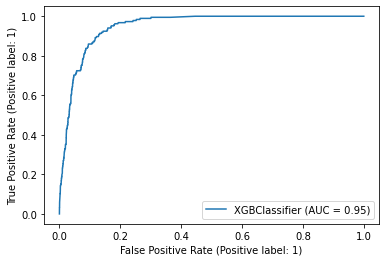

In [51]:
# selección del conjunto de validación
X_val = X.iloc[(n_train):(n_train+n_val)]
y_val = y.iloc[(n_train):(n_train+n_val)]

# Plot de la curva
plot_roc_curve(XGBClassifier(random_state = random_state,
                    n_estimators = int(best_params['params']['nrounds'][0]),
                    learning_rate = float(best_params['params']['eta'][0]), 
                    gamma = int(best_params['params']['gamma'][0]),
                    max_depth = int(best_params['params']['max_depth'][0]),
                    min_child_weight = int(best_params['params']['min_child_weight'][0]) ,
                    subsample = float(best_params['params']['subsample'][0]) ,
                    colsample_bytree = float(best_params['params']['colsample_bytree'][0]),
                    num_parallel_tree = int(best_params['params']['num_parallel_tree'][0]),
                    reg_lambda = int(best_params['params']['lamda'][0]),
                    reg_alpha = int(best_params['params']['alpha'][0])).fit(X_train, y_train), X_val, y_val)  